<a href="https://colab.research.google.com/github/tguinot/difiq/blob/main/gestion_quantitative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import Image
import cvxpy as cp
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import seaborn as sns
from ipywidgets import interact
import matplotlib.pyplot as plt

# Gestion Quantitative 




#### Prérequis mathématiques :
  * Calcul matriciel
  * La loi normale
  * Dérivation de fonction
  * Régression linéaire

Controle du notebook


*   executer une cellule : ctrl + entrer
*   tout executer : ctrl + f9



# Rappels mathématiques / modélisation des actifs

## Un peu de finance

* En gestion de portefeuille on parle souvent de la **net asset value (NAV)** qui est en fait la valorisation du fonds ou d'un portefeuille en argent (en euros par exemple). 



Pour la calculer c'est très facile:

* On prend la quantité $\delta$ d'un actif $i$ 

    **Exemple :** $\delta_i = 1000$ actions société générale

   * On en déduit le montant investi 
   
   $$M_i = \delta_i \mathrm{prix}_i$$
   
       **Exemple :** si le cours de la SG est à 44 euros, $M_i = 1000 \times 44 = 44000\,\mathrm{euros}$

* La **NAV** ou valeur du portefeuille est simplement :

$$NAV = \sum_i  \delta_i \mathrm{prix}_i$$

 Généralement il est plus facile de **raisonner en poids $x$ de l'actif $i$ dans le portefeuille** : 

   $$x_i = \frac{ \delta_i \mathrm{prix}_i}{NAV}$$
   
On peut alors facilement passer des poids aux quantités :
   
   $$\delta_i = \frac{x_i NAV }{\mathrm{prix}_i}$$



In [ ]:
##Calculer le poids de 1000 actions à 44 euros dans un portefeuille de 500000 euros. 
#Le reste est investi en cash, on a donc 2 actifs dans le portefeuille

def get_weight(price, nav, quantity):
  weight = price*quantity/nav
  return weight
  
price = 44
nav = 500000.0
quantity = 1000
poids = get_weight(price, nav, quantity)
print( "Le poids de l'action dans le portefeuille est {0:.0f}%".format(poids * 100))

Le poids de l'action dans le portefeuille est 9%


Si maintenant on regarde ce qu'il se passe **entre deux dates** on a :
* en t:
$$x_i(t)= \frac{ \delta_i(t) \mathrm{prix}_i(t)}{NAV(t)}$$
* en t+1
    $$ x_i(t+1)= \frac{ \delta_i(t) \mathrm{prix}_i(t+1)}{NAV(t+1)}$$
    
    car le prix de **l'action SG a bougé** mais on **a toujours la même quantité** dans le portefeuille. Par contre **le poids a bougé**.


In [ ]:
# Le prix en t = 0 de SG est de 44 euros, et en t = 1 il est de 48 euros
price_0 = 44
price_1 = 48

#On démarre en t = 0 avec une valeur du portefeuille à 500000 euros
nav_0 = 500000
quantity = 1000

#calculer la valeur du portefeuille en cash
def get_cash(quantity,price,nav):
  cash = nav-price*quantity
  return cash

#calculer le nouveaux poids en t+1
def get_new_weight(quantity,new_price,cash):
  new_nav = new_price*quantity + cash
  new_weight = quantity*new_price/new_nav
  return new_weight

cash = get_cash(quantity=quantity,price=price_0,nav=nav_0)

new_weight = get_new_weight(quantity=quantity,new_price=price_1,cash=cash)

print( f"Il y a {cash} euros en investi cash" )
print( "Le poids de l'action dans le portefeuille est {0:.0f}%".format(new_weight * 100))

Il y a 456000 euros en investi cash
Le poids de l'action dans le portefeuille est 10%


On peut calculer la nouvelle NAV:

* La NAV du fonds en $t+1$ devient donc :

$$NAV(t+1) =  \sum_i  \delta_i(t) \mathrm{prix}_i(t+1)$$ 


 * En remplaçant $\delta_i(t)$ on obtient : 
 
$$NAV(t+1) =  NAV(t)\sum_i  x_i(t) \frac{\mathrm{prix}_i(t+1)}{\mathrm{prix}_i(t)}$$ 
 


* Le rendement (en %) d'un actif entre deux periodes est donné par :


$$ \mathrm{rendement}_\mathrm{i}  = \frac{\mathrm{prix}_i(t+1)}{\mathrm{prix}_i(t)}-1$$

* Si $\sum_ix_i = 1$ on obtient :

    $$NAV(t+1) =  NAV(t)\sum_i  x_i(t) \left( \mathrm{rendement}_\mathrm{i} +1\right)$$ 

     et donc :

    $$ \underbrace{\frac{NAV(t+1) }{NAV(t)} -1}_{\text{rendement du fonds}} =  \sum_i x_i \mathrm{rendement}_\mathrm{i}  $$



La contrainte $\sum_ix_i = 1$ est toujours (implicitement) présente lorsque que l'on tient compte du cash dans le portefeuille.  

Lors des phases de recherche de nouvelles strategies **on raisonne très souvent en pourcentage**. 

> Dans la suite du cours nous travaillerons en pourcentage. La NAV ou la valeur du portefeuille en $t=0$ vaut 100% ou 1, **les poids sont aussi exprimés en pourcentage** ainsi que la gestion des risques. On passe ensuite aux quantités ou nombre de lot en pour faire le trading. 


In [ ]:
# on a deux actifs, le poids de l'actif 1 vaut x = 0.5 et le poids de l'actif 2 vaut aussi y=0.5
x = 0.5
y = 0.5
 
#On démarre en t = 0 avec une valeur du portefeuille à 100%
nav_0 = 1

# en t = 1 l'actif 1 a gagné 10% et l'actif 2 a perdu 5%. Quel est la valeur du portefeuille (nav) en %?

def get_new_nav(nav,x,y):
  nav_1 = nav_0*(1 + x*0.1 - y*0.05)
  return nav_1

nav_1 = get_new_nav(nav_0,x,y)
print( "La nav du portefeuille en t+1 est {0:.0f}%".format(nav_1 * 100))

La nav du portefeuille en t+1 est 103%


## Modélisation des rendements

### Mathématiques: La loi normale

La plupart du temps on modélise la dynamique des **rendements** des actifs (actions, futures, obligations...) à l'aide d'une **loi normale**. Si $S_t$ est le prix d'un actif, on rappelle que le rendement est :


$$r_t = \frac{S_t}{S_{t-1}}-1$$
et donc on a comme hypothèse:

$$r_t\sim \mathcal{N}\left(\mu\mathrm{d}t,\sigma^2 \mathrm{d}t\right)$$

ou **$\mu$  est le rendement moyen** de l'actif,  **$\sigma$ la volatilité moyenne** et **$\mathrm{d}t$ le pas de temps**. Ici tout est constant et les paramètres sont **exprimés en année**.  



> La quantité $\mu$ est communement appélé **"expected return"**. En excès du taux sans risque ($\mu-r_f$) on parle de **"prime de risque"** (risk premia).



En calcul stochastique on a exactement la meme chose :

\begin{eqnarray*}
\frac{dS_t}{S_t}  &=& \mu \mathrm{d}t+\sigma\mathrm{d}Wt  \\
&=& \mu \mathrm{d}t+\sigma\sqrt{\mathrm{d}t}\epsilon_t  \\
r_t&\sim& \mathcal{N}\left(\mu\mathrm{d}t,\sigma^2{\mathrm{d}t }\right)
\end{eqnarray*}
 

ou $\epsilon_t \sim \mathcal{N}(0,1)$.
Dans la vraie vie les paramètres ne sont pas contants.

Comme les paramètres sont exprimés en année il faut savoir passer d'une fréquence à une autre. Par exemple si vous avez calculé une volatilité sur des données hebdomadaires **il faut savoir l'annualiser**.

In [ ]:
#si on suppose qu'il a 260 jours de trading dans une année

daily_return = 0.0005  
daily_vol = 0.6/100

def get_annualised_daily_return(daily_ret,annualisation_coef=260):
  ann_ret = daily_ret*annualisation_coef
  return  np.round(ann_ret,2)


def get_annualised_daily_vol(daily_vol,annualisation_coef=260):
  ann_vol = daily_vol*annualisation_coef**0.5
  return np.round(ann_vol,2)

print(f"La volatilité annualisée est {get_annualised_daily_vol(daily_vol)*100}%")
print(f"Le rendement annualisé est {get_annualised_daily_return(daily_return)*100}%")

La volatilité annualisée est 10.0%
Le rendement annualisé est 13.0%


Pour estimer le rendement et la volatilité attendu d'un actif, on peut utiliser les estimateurs historiques. Par exemple :

$\hat{\mu}=\frac{1}{t_n-t_0}\sum_{i=0}^n\mathrm{rendement}(t_{i},t_{i+1}) $
  
$\hat{\sigma}^2= \frac{1}{t_n-t_0}\sum_{i=0}^n\mathrm{rendement}(t_{i},t_{i+1})^2$



> Ici l'estimateur de la variance est non-centré. Il n'y a pas de methode universelle pour les calculs d'estimateurs. Cela depend du chercheur et de vos hypothèses: biaisé ou non, hétéroscédasticité, pondération des observations ect...



Souvent on utilise les estimateurs historiques en prenant la moyenne et l'ecart type des rendements passés, typiquement 1 an en daily. Il est important de noter que

  * On sait (environ) calculer des volatilités et des corrélations

  * On sait mal calculer des tendances, des espérances de rendements


> La recherche est toujours tres active sur le developpement de méthodes pour connaitre les rendements espérés. Voir par exemple [ici](http://www.thierry-roncalli.com/download/lwp-tf.pdf) ou [ici](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2780280).



Il est important de comprendre que la **volatilité est une mesure de risque très importante** quand on est sous hypothèse gaussienne.




In [ ]:
Image(url='https://upload.wikimedia.org/wikipedia/commons/a/a9/Empirical_Rule.PNG')

Les moments d'ordre supérieur qui sont parfois utilisés **lorsque l'hypothèse de rendement gaussien n'est plus vérifiée**. En particulier **la skewness** qui mesure l'asymetrie d'une distribution.


In [ ]:
Image(url='https://www.benchmarksixsigma.com/forum/uploads/monthly_2018_08/image.png.219ef88bbcbfdb0a921a8006fed3a9ad.png',width=800,height=400)


## Derivation de matrice et regression lineaire


Pour la suite du cours on aura aussi besoin de savoir deriver des matrices. 

Soit $w=\left(\begin{array}{c}w_{1} \\ \vdots \\ w_{n}\end{array}\right)$ et $f(w)$ une fonction a valeur dans R. On a:

$$\frac{\partial f(w)}{\partial w}=\left(\begin{array}{c}\frac{\partial f}{\partial w_{1}} \\ \vdots \\ \frac{\partial f}{\partial w_{n}}\end{array}\right)$$

Par exemple pour le produit scalaire $f(w) = w^\top \mu= \mu^\top w$ on a:
$$\frac{\partial f(w)}{\partial w}=\left(\begin{array}{c}\mu_{1} \\ \vdots \\ \mu_{n}\end{array}\right)$$

> Par convention on ecrira la derive d'un scalaire en vecteur colonne

Pour une forme quadratique on a $f(w) = w^\top A  w$ la derivation est un peu plus fastidieuse.




Par exemple pour $n=2$ on a $f(w) = w_1^2a_{11}+w_1w_2a_{12}+w_1w_2a_{21}+w_2^2a_{22}$. Si on derive par rapport a $w_1$ on obtient:


$$\frac{\partial f(w)}{\partial w_1}= 2w_1a_{11}+w_2a_{12}+w_2a_{21} = (Aw)_1 + (A^\top w)_1$$

La forme generale s'ecrit:
$$\frac{\partial f(w)}{\partial w_k}=   \sum_{j=1}^{n} a_{k j} w_{j}+\sum_{i=1}^{n} a_{i k} w_{i}=(Aw)_k+(A^\top w)_k$$




Si on fait ca pour chaque $k$ on obtient:

$$\frac{\partial f(w)}{\partial w}=Aw+A^\top w $$
De plus si $A$ est symetrique (une matrice de correlation par exemple) on a $\frac{\partial f(w)}{\partial w}=2Aw $





### Application: la regression lineaire

Imaginons que l'on souhaite predire ou expliquer les rendements d'une action $y$ par un ensemble de facteur $X$ avec un modele lineaire tel que:
$$y \sim \mathcal{N}(x^\top\beta,\sigma_\epsilon)$$

 On suppose donc que $y = x^\top\beta +\epsilon$ et que l'on a assez de donnees pour estimer $\beta$.

Disons que l'on a $n$ data points et $p$ facteurs. La regression consiste a minimiser la somme des carres des erreurs du model ($e$) au carre. Soit $\mathrm{y}$ et $\mathrm{X}$ les matrice de data, on a:

$e^\top e = (\mathrm{y}-\mathrm{X}\beta)^\top (\mathrm{y}-\mathrm{X}\beta)=\mathrm{y}^\top \mathrm{y}-\mathrm{y}^\top\mathrm{X}\beta-\beta^\top \mathrm{X}^\top  \mathrm{y}+\beta^\top\mathrm{X} ^\top \mathrm{X}\beta $



On remarquera que $\mathrm{y}^\top\mathrm{X}\beta=\beta^\top \mathrm{X}^\top y$ On veut minimiser, on derive:

$$\frac{\partial e^\top e}{\partial \beta} = 0 + 2\mathrm{X} ^\top \mathrm{X}\beta - 2 \mathrm{X}^\top\mathrm{y}$$

Et on obtient an annulant la derive $\beta = (X^\top X)^{-1}X^\top y$

## Economique: modèle d'évaluation des actifs financiers (CAPM)

  * Modèle introduit par Sharpe en 1964
  * Utilisé pour calculer la rentabilité attendu d'une action...
  
  
  * ... sous de nombreuses hypothèses
     * Que tout le monde cherche à optimiser un critère moyenne/variance  (tout le monde est averse au risque et les rendements sont Gaussiens)
     * Qu’il n’y a pas de cout de transaction
     * Que tout le monde a le même horizon d’investissement
     * Qu’il n’y a pas de contraintes de portefeuille
     * Que tout le monde a les mêmes anticipations (et la même information)

Alors le CAPM nous dit que :


**rentabilité d'une action - rentabilité taux = beta x ( rentabilité du marché - rentabilité taux) + risque spécifique**



Soit sous forme mathématique :

$$r_t^i - r_f = \beta_{i,m}\left( r_t^m - r_f\right) + \epsilon_t^i $$

avec $\epsilon_t^i \sim \mathcal{N}(0,\sigma_{\epsilon_i})$ le risque idiosyncrasique, spécifique à l'action $i$. C'est un risque diversifiable.
On en déduit le lien entre l'espérance de rendement de l'action $i$ et l'espérance de rendement du marché :

$$\underbrace{\mathbb{E}[r_t^i] - r_f}_{\text{prime de risque de l'actif}} = \beta_{i,m}\left( \underbrace{\mathbb{E}[r_t^m] - r_f}_{\text{prime de risque de marché}}\right) $$


* Le terme $\pi_i = \mathbb{E}[r_t^i] - r_f$ est appelé **prime de risque de marché** et $\mathbb{E}[r_t^i]$ le rendement espéré de l'action (expected return). 


* La quantité $\beta_{i,m}$ est appelée **le beta de marché**. On le retrouve en regressant les performances de l'action sur les performances du marché :

$$ \beta_{i,m} = \frac{ \mathrm{cov}\left(r_t^m,r_t^i \right)}{\sigma^2(  r_t^m)}$$

Pour un gérant de portefeuille l'intérêt est le suivant: vous pouvez avoir **une vue de marché** et en déduire **des vues individuelles grace aux betas** sur chaque actif.


> le CAPM est un modèle à un seul facteur. Des extensions ont été proposées.
  * 3 facteurs (Fama-French, 1993)
  * 4 facteurs (Carhart, 1997)
  $$r_t^i-r_f=\alpha^i+\beta_{i,m}\left( r_t^m - r_f\right)+\underbrace{\beta_{i,HML}r_t^{HML}}_{\text{value factor}}+\underbrace{\beta_{i,SMB}r_t^{SMB}}_{\text{size factor}}+\underbrace{\beta_{i,UMD}r_t}_{\text{momentum factor}}+\epsilon_t^i$$
  
  Si le sujet vous intéresse [voir ici](http://www.thierry-roncalli.com/download/factor-investing.pdf).

# Stratégies de gestion simples

## Placer au taux sans risque

### Définition

* Quand on place de l'argent sur un compte il évolue au taux sans risque en continue. 


* Si le taux est de 3% par année, sur une année de 365 jours un placement rapporte 3%/365 par jour.


* Pour les banques on prendra en référence le taux eonia (Euro OverNight Index Average) pour les strategies en euro.

<Axes: >

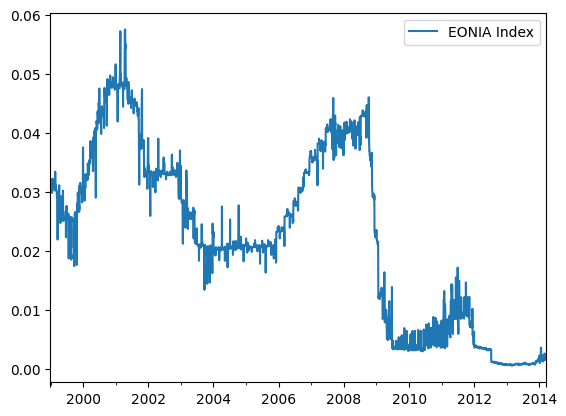

In [ ]:
eonia = pd.read_csv(r"https://raw.githubusercontent.com/jcr-lyxor/DIFIQ/master/data/eonia.csv",sep=";",index_col=0, parse_dates=True,infer_datetime_format=True) 
eonia.plot()


* Le taux bouge tous les jours. 


* Pour connaitre la valeur d'un placement au taux sans risque 1 jour depuis 2000 il suffit de calculer chanque jour la valeur du placement.  

$$r_{t} =  \mathrm{eonia}_{t-1} \mathrm{d}t $$

avec $\mathrm{d}t= \frac{\mathrm{dates}_t-\mathrm{dates}_{t-1}}{365}$. 



Ensuite comme pour n'importe quelle autre actif / stratégie, quand on a les rendements, on compose pour obtenir la valeur de l'investissement :

\begin{eqnarray}
  \mathrm{valeur}_t &=&   \mathrm{valeur}_{t-1} + \mathrm{valeur}_{t-1}r_{t}  \\
 \mathrm{valeur}_t &= &  \mathrm{valeur}_{t-1} (1+r_{t}) 
\end{eqnarray}





### Exercice


<Axes: title={'center': 'NAV'}>

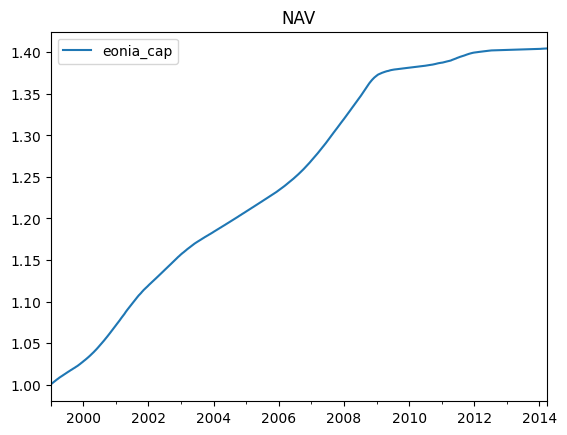

In [ ]:
#calcul du pas de temps
dt = pd.DataFrame(eonia.index[1:].values-eonia.index[:-1].values,columns=["dt"])
#calcul du rendement de eonia, vaut 0 en date 0
r_eonia =  np.array(eonia['EONIA Index'])*( np.hstack((dt["dt"].shift(-1).dt.days/365,1/365)))
r_eonia = pd.DataFrame(np.nan_to_num(r_eonia),index=eonia.index)
#cumul le taux
eonia_cap = pd.DataFrame((1+r_eonia.values).cumprod() ,columns=["eonia_cap"],index=eonia.index)
eonia_cap.plot(title="NAV")


## Le portefeuille equally weighted


### Définition

Dans la suite on notera :

* $n$ le nombre d'actifs dans le portefeuille

* $\Sigma$ la matrice de covariance 

* $\mu$ le vecteur des tendances des actifs

* $x$ le vecteur de poids des actifs.

* $V_t$ la valeur du portefeuille.

Le portefeuille le plus simple est le portefeuille "1/n":

$$x_i = \frac{1}{n}$$

 * On a **le même poids** dans chaque actif. **On devra rebalancer** le portefeuille pour les maintenir.

 * Différent du portefeuille "buy and hold" ou **les poids dérivent**.


**Avantages**
 * C'est le portefeuille le plus diversifié en poids.  
 * Stratégie « **take profit** »: On vend les actifs dont le prix monte plus que les autres. On rachète ceux dont le prix baisse.
 * On vend à la hausse, on achète à la baisse -> on gagne grâce à la vol. 


**Inconvénients**
 * On se réexpose quand un actif baisse: théoriquement, un seul actif convergeant vers un prix nul entraine tout le portefeuille vers 0.
 * Pour des actifs très différents (actions vs bonds) le même poids ne fait pas de sens…

Pour juger de la qualité d'une stratégie, 4 mesures sont vraiment importantes :

  * Le rendement annualisé : $\mu = \left(\frac{V_T}{V_0}\right)^{1/n}-1$
  
  * La volatilité annualisé : $\sigma = \frac{1}{T-t_0}\sqrt{\sum_{t=0}^T\left( r_t -\bar{r}\right)^2}$
  
  * Le ratio de sharpe : $\theta =  \frac{\mu-r}{\sigma}$
  
  * Le maximum drawdown : $ \text{MDD}=\max_{\tau\in (0,T)}\left[\max_{t \in (0,\tau)} V_t- V_\tau \right]$
 


### Exercice


1.   Simuler le portefeuille 1/n et buy and hold. 
2.   Calculer le taux de rendement, la volatiltié et le ratio de sharpe.
3. Calculer sa volatilité rolling (ex-post).




On peut regarder les datas et les grapher:

In [ ]:
data = pd.read_csv(r"https://raw.githubusercontent.com/jcr-lyxor/DIFIQ/master/data/data.csv",sep=";",index_col=0,  parse_dates=True,infer_datetime_format=True)

<Axes: >

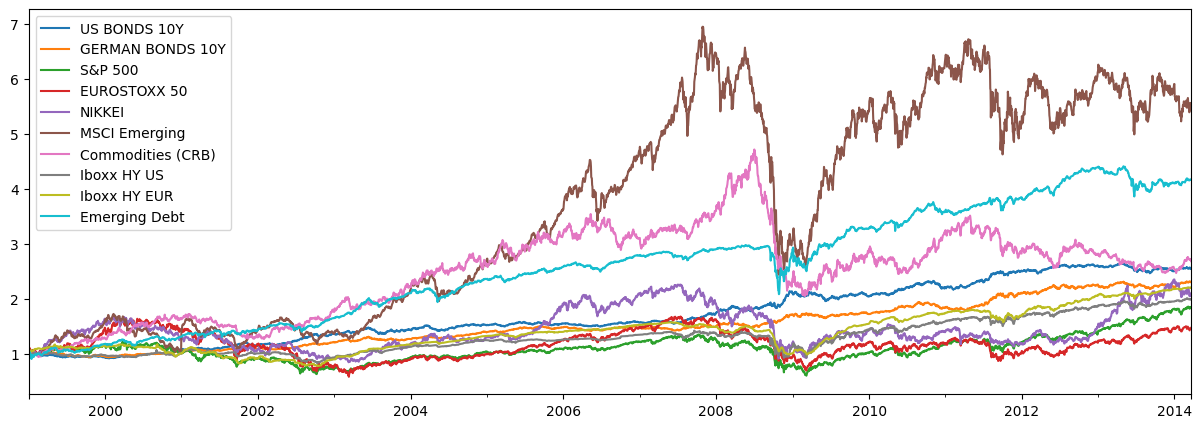

In [ ]:
data.plot(figsize = (15,5))


In [ ]:
data

,US BONDS 10Y,GERMAN BONDS 10Y,S&P 500,EUROSTOXX 50,NIKKEI,MSCI Emerging,Commodities (CRB),Iboxx HY US,Iboxx HY EUR,Emerging Debt
1998-12-31,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1999-01-01,1.000088,1.000119,1.000088,0.999997,1.000075,0.999947,0.999947,0.999947,0.999997,0.999947
1999-01-04,0.998745,1.009510,0.996735,1.060171,0.979989,1.015645,1.012141,1.000688,0.999989,1.015679
1999-01-05,0.995850,1.009253,1.006658,1.073498,0.964796,1.025548,1.005095,1.001035,0.997093,1.029445
1999-01-06,0.998002,1.011184,1.028436,1.103005,0.974469,1.049137,1.028579,1.003282,0.997608,1.032128
...,...,...,...,...,...,...,...,...,...,...
2014-03-17,2.560856,2.314770,1.837997,1.448785,2.086956,5.494743,2.713024,1.992431,2.201402,4.164547
2014-03-18,2.564731,2.315104,1.850866,1.459718,2.079005,5.565087,2.723152,1.998371,2.205044,4.174915
2014-03-19,2.544136,2.310266,1.839453,1.462152,2.098553,5.445955,2.725187,1.988189,2.208686,4.171677
2014-03-20,2.542538,2.301227,1.853117,1.466529,2.065275,5.463003,2.696875,1.994977,2.202810,4.169410


Pour construire le portefeuille on va calculer les rendements de chancun des actifs:

$$r_t^i = \frac{P_t^i}{P_{t-1}^i}-1$$

En python on fait simplement:

In [ ]:
R = data / data.shift()-1
R = R.fillna(0)
R.head()

,US BONDS 10Y,GERMAN BONDS 10Y,S&P 500,EUROSTOXX 50,NIKKEI,MSCI Emerging,Commodities (CRB),Iboxx HY US,Iboxx HY EUR,Emerging Debt
1998-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1999-01-01,0.000088,0.000119,0.000088,-0.000003,0.000075,-0.000053,-0.000053,-0.000053,-0.000003,-0.000053
1999-01-04,-0.001343,0.009390,-0.003352,0.060174,-0.020085,0.015699,0.012194,0.000741,-0.000008,0.015733
1999-01-05,-0.002898,-0.000255,0.009956,0.012571,-0.015503,0.009750,-0.006961,0.000347,-0.002896,0.013553
1999-01-06,0.002161,0.001913,0.021634,0.027487,0.010026,0.023002,0.023365,0.002244,0.000516,0.002605


* Finalement les rendements du  portefeuille 1/n sont donnés par: 


$$r_t^p = \sum_i r^i_t x_{1/n}^i$$ 


* Matriciellement on a : 

$$r_t^p = r_t^\top x_{1/n}$$

In [ ]:
#calcul du nombre d'actifs
n = R.columns.size
n

10

In [ ]:
#calcul des poids
x_1n = np.ones(n) / n
print (x_1n)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [ ]:
#calcul des rendements du portefeuille
R_1n = np.dot(R,x_1n)
R_1n = np.nan_to_num(R_1n)

In [ ]:
#calcul du backtest (NAV) en cumulant
backtest = pd.DataFrame((R_1n+1).cumprod(),index = data.index,columns = ["1/n"])

#ajoutons BAH
backtest["BAH"] = (pd.DataFrame((R.fillna(0)+1).cumprod(),index = data.index)).sum(1)/n

#ajoutons eonia pour comparer
backtest["Eonia"] = eonia_cap

In [ ]:
backtest.head()

,1/n,BAH,Eonia
1998-12-31,1.000000,1.000000,1.000263
1999-01-01,1.000015,1.000015,1.000351
1999-01-04,1.008930,1.008929,1.000438
1999-01-05,1.010712,1.010827,1.000526
1999-01-06,1.022330,1.022583,1.000614


<Axes: >

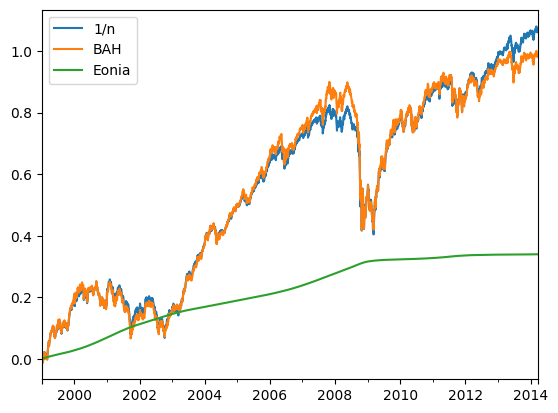

In [ ]:
np.log(backtest).plot()

In [ ]:
def compute_rolling_volatility(backtest,window,is_ewm=False):
  if is_ewm:
    rolling_volatility = (backtest/backtest.shift() -1).ewm(halflife=window,min_periods=window).std()*np.sqrt(260) 
  else:
    rolling_volatility = (backtest/backtest.shift() -1).rolling(window,min_periods=window).std()*np.sqrt(260) 

  return rolling_volatility
 

@interact(window=(10,1000,10),is_ewm=False)
def compute_rolling_vol(window = 60, is_ewm=False):
  vol = compute_rolling_volatility(backtest,window,is_ewm) 
  vol = vol.ffill()
  ax = vol.plot()
  plt.show()
  
                    

interactive(children=(IntSlider(value=60, description='window', max=1000, min=10, step=10), Checkbox(value=Fal…

# Control de volatilité

### Définition

**Le calcul de volatilité rolling nous montre :**

* Que la volatiltié bouge beaucoup dans le temps, ce qui veut dire que le risque bouge dans le temps donc que la probabilité de perdre x% est différente d'une année sur l'autre. 

Mais, on peut faire une stratégie de controle de volatilité, **le vol-target**.




* L'idée est la suivante : si les rendements suivent une loi normale disons $r_t\sim \mathcal{N}(\mu,\sigma_t)$, on a vu que un estimateur du risque $\hat{\sigma_t}$ est donné par la volatilité historique. 


* Disons que je veux avoir une volatilité qui soit toujours à peu près à $\sigma^\star = 10\%$. On voit alors que :


$$ r_t\frac{\sigma^\star}{\sigma_t}\sim \mathcal{N}\left(\mu\frac{\sigma^\star}{\sigma_t},\sigma^\star\right) $$ 





 
Il suffit donc d'investir uniquement une proportion $x_{vt} = \frac{\sigma^\star}{\hat{\sigma_t}}$ dans l'actif pour obtenir une volatilité cible égale à $10\%$. 

 * Si $x_{vt}>1$ on emprunte au taux sans risque pour acheter de l'actif risqué : **leverage**
 * Si $x_{vt}<1$ on vends de l'actif risqué pour placer au taux sans risque  : **deleverage**
 


Utile pour :


*   pricing: controler la vol
*   combiner des classes d'actif 
*   preparer les datas pour les modeles



### Exercice sous excel

Faire un vol target à 5% du portefeuille 1/n et comparer la volatilité rolling

In [ ]:
vol = compute_rolling_volatility(backtest,660)
rendements_1_sur_n = backtest["1/n"].pct_change()

In [ ]:
vol_cible = 0.05
fraction_a_investir = vol_cible /  vol["1/n"] 

<Axes: >

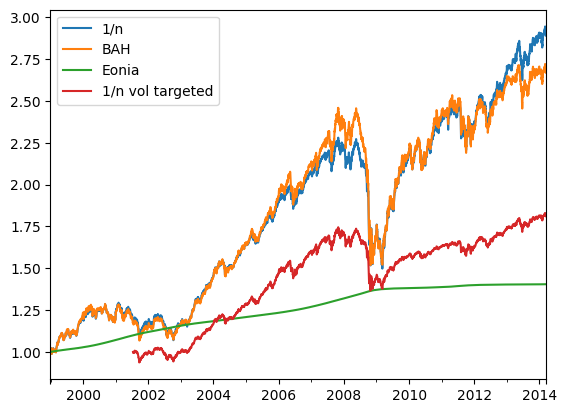

In [ ]:
backtest["1/n vol targeted"] = (1+fraction_a_investir.shift()*rendements_1_sur_n + (1-fraction_a_investir.shift())*r_eonia.iloc[:,0].values).cumprod()
backtest.plot()


In [ ]:
 backtest.pct_change().std()*260**0.5

1/n                 0.091379
BAH                 0.095699
Eonia               0.001325
1/n vol targeted    0.053179
dtype: float64

<Axes: >

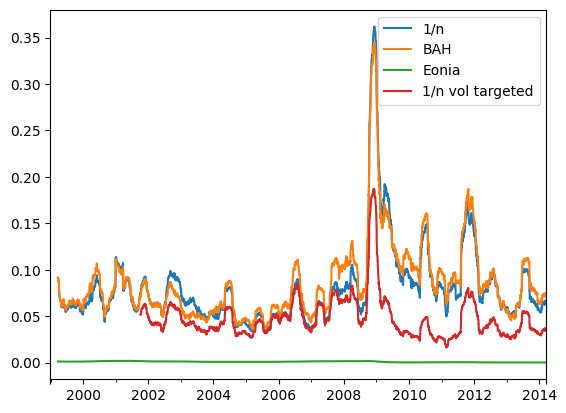

In [ ]:
(backtest.pct_change().rolling(60).std()*260**0.5).plot()

Attention a la variance et aux cout de transactions

In [ ]:
 
@interact(window=(10,1000,10))
def compute_rolling_vol(window = 60):
  vol_cible = 0.05
  vol =compute_rolling_volatility(backtest,window)
  rendements_1_sur_n = backtest["1/n"].pct_change()
  fraction_a_investir = vol_cible /  vol["1/n"] 
  fraction_a_investir.loc['2004':].plot(title ='fraction à investir')
  plt.show()           

interactive(children=(IntSlider(value=60, description='window', max=1000, min=10, step=10), Output()), _dom_cl…

# Smart Beta


## Petit rappel sur la matrice de covariance et de correlation

**Petit rappel sur la matrice de covariance et de correlation**


La matrice de corrélation $C$ nous donne les différentes corrélations entre les actifs. On peut construire la matrice de variance covariance $\Sigma$ à partir de cette matrice :

$$ C =\left(\begin{array}{ccccc}
1\\
\rho_{1,2} & 1\\
\rho_{1,3} & \rho_{2,3} & 1\\
\rho_{1,4} &  \rho_{2,4} & \rho_{3,4} & 1\\
\rho_{1,5} & \rho_{2,5} & \rho_{3,5} &  &1
\end{array}\right) \qquad \Rightarrow \qquad \Sigma =\left(\begin{array}{ccccc}
\sigma_{1}^{2}\\
\sigma_{1}\sigma_{2}\rho_{1,2} & \sigma_{2}^{2}\\
\sigma_{1}\sigma_{3}\rho_{1,3} & \sigma_{2}\sigma_{3}\rho_{2,3} & \sigma_{3}^{2}\\
\sigma_{1}\sigma_{4}\rho_{1,4} & \sigma_{2}\sigma_{4}\rho_{2,4} & \sigma_{3}\sigma_{4}\rho_{3,4} & \sigma_{4}^{2}\\
\sigma_{1}\sigma_{5}\rho_{1,5} & \sigma_{2}\sigma_{5}\rho_{2,5} & \sigma_{3}\sigma_{5}\rho_{3,5} & \sigma_{4}\sigma_{5} & \sigma_{5}^{2}
\end{array}\right)$$
 


Mathématiquement on a :

$$ \Sigma = C \cdot \sigma\sigma^\top $$

ou $\sigma$ est le vecteur des volatilités.
On peut donc facilement passer de l'une à l'autre.

In [ ]:
cor = R.tail(300).corr()*100 #correlation matrix over last 300 last days

#ou

cov = R.tail(300).cov()
cor  = cov / np.outer(np.diag(cov)**0.5,np.diag(cov)**0.5)
cor*100

,US BONDS 10Y,GERMAN BONDS 10Y,S&P 500,EUROSTOXX 50,NIKKEI,MSCI Emerging,Commodities (CRB),Iboxx HY US,Iboxx HY EUR,Emerging Debt
US BONDS 10Y,100.000000,57.571199,-12.494852,-13.740820,-29.777296,6.705059,5.566815,39.722083,0.236596,48.240615
GERMAN BONDS 10Y,57.571199,100.000000,-12.079789,-19.091903,-19.742880,-4.724682,7.015921,18.522748,12.136881,32.203145
S&P 500,-12.494852,-12.079789,100.000000,57.737933,60.185351,74.285156,18.637337,59.129453,28.142319,32.413792
EUROSTOXX 50,-13.740820,-19.091903,57.737933,100.000000,39.265301,51.012157,18.801136,39.261142,45.692250,31.918408
NIKKEI,-29.777296,-19.742880,60.185351,39.265301,100.000000,48.328798,12.667373,23.032599,26.662244,14.442275
MSCI Emerging,6.705059,-4.724682,74.285156,51.012157,48.328798,100.000000,23.752454,57.002843,29.950409,49.051629
Commodities (CRB),5.566815,7.015921,18.637337,18.801136,12.667373,23.752454,100.000000,14.175127,19.164827,18.810055
Iboxx HY US,39.722083,18.522748,59.129453,39.261142,23.032599,57.002843,14.175127,100.000000,30.813836,63.952972
Iboxx HY EUR,0.236596,12.136881,28.142319,45.692250,26.662244,29.950409,19.164827,30.813836,100.000000,42.371078
Emerging Debt,48.240615,32.203145,32.413792,31.918408,14.442275,49.051629,18.810055,63.952972,42.371078,100.000000


On peut utiliser une visualisation pour mieux comprendre la structure de correlation de nos données. Par exemple :

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


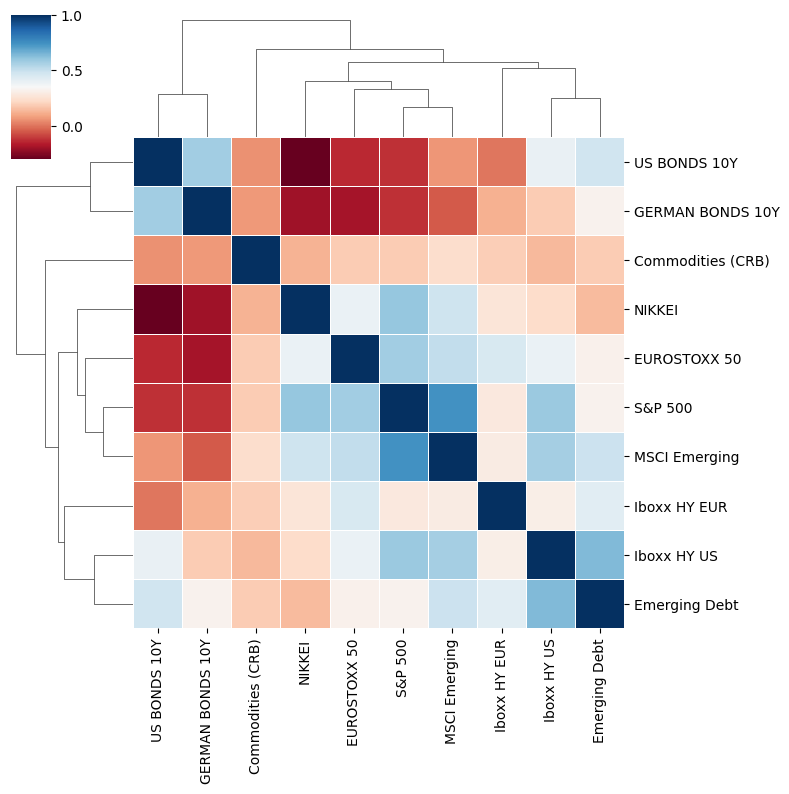

In [ ]:
_=sns.clustermap(cor ,figsize=(8,8), linewidths=.5 ,square=True,cmap="RdBu")

 La matrice de variance covariance est à la base de nombreuses méthode de gestion des risuqe: vol target, value at risk, risk budgeting...

La variance d'un portefeuille $x$ est donnée par : 

$$x^\top\Sigma x = \sum_i \sum_j \rho_{ij}\sigma_i\sigma_j x_ix_j $$

On peut alors déduire la volatilité d'un portefeuille $x$:

$$\sigma(x)=\sqrt{x^\top\Sigma x}$$

Prennons un exemple avec deux actifs. On obtient:

$$\sigma^2(x_1 r_1 + x_2 r_2) = x_1^2 \sigma^2_1+ x_2^2 \sigma^2_2+ 2x_1 x_2 \sigma_1\sigma_2\rho $$

**Questions**
* Quel est l'impact de la corrélation sur la variace d'un portefeuille long only ?
* D'un portefeuille long short ?
* On voudra toujours avoir $\Sigma$ **définie positive**. Pourquoi ?

Par exemple on peut  calculer la volatilité du portefeuille 1/n : 

In [ ]:
vol_1n = np.sqrt(x_1n.dot(cov).dot(x_1n))*np.sqrt(260)
print(f'la volatilité ex-ante du potefeuille 1/n est {np.round(vol_1n*100,1)}%')

la volatilité ex-ante du potefeuille 1/n est 7.1%


De meme le rendement espéré du portefeuille $x$ est simplement :


$$\mu(x) = \mu^\top x$$

0n peut prendre également les rendements historiques pour estimer le vecteur $\mu$ qui sera en fait la moyenne des rendements :

<Axes: >

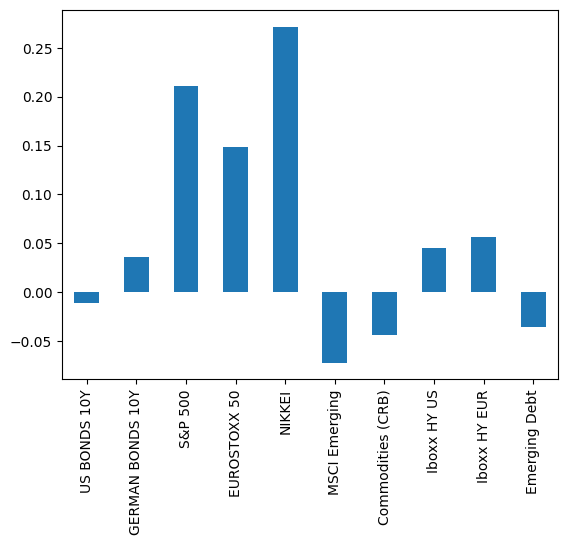

In [ ]:
mu = R.tail(300).mean(axis = 0) #calculated over last 300 days
mu_ann =  mu* 260
mu_ann.plot(kind="bar")
 

In [ ]:
mu_1n = mu_ann.dot(x_1n)
print(f'le rendement attendu du potefeuille 1/n est {np.round(mu_1n*100,1)}%')

le rendement attendu du potefeuille 1/n est 6.1%


La plupart des méthodes d'optimisation de portefeuille sont basées sur ces deux quantités. 

Finalement **si tout est gaussien, les rendements du portefeuille $x$ sont aussi gaussiens** et on a :

$$r_x \sim \mathcal{N}(\mu(x),\sigma^2(x))$$



> Cette hypothèse est importante en gestion de portefeuille car elle est implicite à beaucoup de methodes d'optimisation. Attention lorsaue vous optimisez des portefeuilles d'options ou de hedge funds pas exemple. 



## Les portefeuilles minimum variance

### Définition

**Le portefeuille minimum variance** est simplement le portefeuille qui minimise la variance des rendements du portefeuille.

\begin{eqnarray}
x^{\star } &=&\arg \min \frac{1}{2}x^{\top }\Sigma x \\
&\text{u.c.}&\left\{
\begin{array}{l}
x\in \mathcal{C} \\
\mathbf{1}^{\top }x=1 \\
x\geq \mathbf{0}%
\end{array}%
\right. \notag
\end{eqnarray}


Si on enlève les contraintes $x\geq \mathbf{0}$ et $x\in \mathcal{C}$ on peut avoir une formule fermée. Le langangien du probleme est:


$$l(x,\lambda) =  \frac{1}{2}x^{\top }\Sigma x - \lambda(\mathbf{1}^{\top }x-1)$$




on dérive par rapport à $x$ et on obtient:


$$x^\star = \lambda\Sigma^{-1}\mathbf{1} $$ 


On voit apparaitre l'inverse de matrice de variance covariance $\Sigma^{-1}$ appelée aussi matrice d'information $\mathcal{I}$. C'est "l'équivalent" de la division pour les matrices. 

Pour obtenir la somme des poids égale à 1, on ne peut agir que sur le paramètre lambda. C'est ce que fait l'optimiseur normalement. Ici on peut augmenter le paramètre "à la main" jusqu'a trouver 1 ou il y a une formule fermée:


$$\lambda = \frac{1}{\mathbf{1}^\top\Sigma^{-1}\mathbf{1}} $$





### Exercice
1. Calculer l'inverse de la matrice de covariance. 
2. Calculer les poids du MV avec  $\lambda = 1$.  
3. Calculer les poids du MV avec la contrainte de somme des poids.  

In [ ]:
lambda_ = 1   
inv_cov = np.linalg.inv(cov)

 
x_mv = lambda_ * inv_cov.dot(np.ones(n))
print(f'la somme des poids du portefeuille optimal est {x_mv.sum()}')

la somme des poids du portefeuille optimal est 343664.2051295683


La somme des poids est bien loin de 1. Si maintenant on calcule le bon lagrangien on obtient: 

In [ ]:
inv_cov = np.linalg.inv(cov)

lbda =   1/inv_cov.sum().sum()
inv_cov = np.linalg.inv(cov)
x_mv = lbda * inv_cov.dot(np.ones(n))

print(f'La somme des poids du portefeuille minimum variance est {x_mv.sum()}')
 

vol_mv = np.sqrt(x_mv.dot(cov).dot(x_mv))*np.sqrt(260)
print(f'La volatilité ex-ante du potefeuille minimum variance est {np.round(vol_mv*100)}%')


La somme des poids du portefeuille minimum variance est 1.0
La volatilité ex-ante du potefeuille minimum variance est 3.0%


## Le portefeuille moyenne variance

### Définition

Dans le cas **minimum variance**, on a juste **optmisé sur le risque**. On peut prendre en compte les **estimateurs de tendances esperées** des actifs pour ajouter une dimension "directionnelle". 



\begin{eqnarray*}
x^{\star } &=&\arg \min \frac{1}{2}x^{\top }\Sigma x -\color{blue}{\phi \mu^\top x} \\
&\text{u.c.}&\left\{
\begin{array}{l}
x\in \mathcal{C} \\
\mathbf{1}^{\top }x=1 \\
x\geq \mathbf{0}
\end{array}
\right.  
\end{eqnarray*}

* Le paramètre $\phi$ est l'aversion au risque. 
    *  ce paramètre sert à controler le risque, un peu comme le vol-target.




 
Pour résoudre ce probleme avec plusieurs contraintes on va utiliser **l'optimisation convexe** plus précisément **la programmation quadratique** qui est très utilisée en finance quantitative.  



*  Généralement on a un solver "qprog" qui fait le travail:

\begin{equation*}
 \begin{aligned}
 & \underset{x}{\text{minimize}}
 & & J(x) = \frac{1}{2} \mathbf{x}^T Q \mathbf{x} + c^T \mathbf{x} \\
 & \text{sous contrainte de :} 
 & & A\mathbf{x} \leq \mathbf b \mbox{  (contraintes d'inégalité)} \\
 & 
 & &     E\mathbf{x} = \mathbf d  \mbox{  (contraintes d'égalité)}
 \end{aligned}
\end{equation*}


> On trouve un solver qprog dans tous les langages et ils sont toujours sous ce format. On voit que si on a $Q=\Sigma$, $c=0$, $E=[1,...1]$, $d=1$ on a exactement le probleme du minimum variance. En python vous pouvez utiliser [quadprog](https://pypi.org/project/quadprog/), [cvxpy](https://pypi.org/project/cvxpy/) ou [cvxopt](https://pypi.org/project/cvxopt/).



En ayant tous les couple volatilité et tendance on obtient la **frontière efficiente**:

In [ ]:
 
Image(url='https://upload.wikimedia.org/wikipedia/commons/e/e1/Markowitz_frontier.jpg' , height=500 ,width=800)

Imaginons un analyste: score +3 sur SP500
, je peux l'interpreter comme ratio de Sharpe: $\mu/\sigma=3$.

Vous estimez la volatilité du SP500 à 10%. Donc
$\mu = 3\sigma=30\%$


Dans le portefeuille moyenne variance il faut donc **estimer les espérences de tendance des actifs**. Il n'y a pas vraiment de réponse unique à cette estimation. Cela dépend de la stratégie :
* Dans une stratégie de suivi de tendance on utilise une moyenne de rendements passés
* On peut utiliser un modèle AR(1) court terme : $r_{t+1} = \rho r_t + \epsilon_t$
* des vues d'analystes macro
* un modèle factoriel de prime de risque
* des vues de marché implicites 

### Exercice
Calculer la frontiere efficiente sur l'unviers multi-asset.


Si on fait abstraction des contraintes de poids positifs et de budget, le langangien du problème est :


$$l(x,\phi) =  \frac{1}{2}x^{\top }\Sigma x - \phi\mu^{\top }x$$


on dérive et on obtient :


$$x^\star = \phi\Sigma^{-1}\mu $$ 



Disons que $\phi = 0.5$, on peut calculer la solution :

In [ ]:
phi = 0.0005
x_mvo = phi * inv_cov.dot(mu)
print (x_mvo)

[ 0.0097051   0.01143032  0.02118486  0.00046095  0.00035032 -0.00923344
 -0.00317751 -0.00029946  0.02053195 -0.01102247]


Regardons notre risque:

In [ ]:
vol_mvo = np.sqrt(x_mvo.dot(cov).dot(x_mvo))*np.sqrt(260)
vol_mvo 

0.0019114455188492321

et le rendement espéré :

In [ ]:
mu_mvo = x_mvo.dot(mu)
mu_mvo

2.8104799780990852e-05

Ce portefeuille est il meilleur que le minimum variance et le 1/n  ?

Un exemple cxvpy. En générale on réécrit le problème comme un problème de maximisation de rendement:


\begin{eqnarray*}
x^{\star } &=&\arg \max  \color{blue}{\mu^\top x} \\
&\text{u.c.}&\left\{
\begin{array}{l}
x\in \mathcal{C} \\
x^{\top }\Sigma x \leq \sigma^\star \\
\end{array}
\right.  
\end{eqnarray*}

Facilement solvable avec cvxpy:


In [ ]:
#Allocate variables
x = cp.Variable(10)
 
# Form objective.
mu_ptf = x.T@mu*260
obj = cp.Maximize(mu_ptf)

# From constraints
var_ptf = cp.quad_form(x,cov*260)
constraints = [ 
               var_ptf<=0.1**2, #contrainte de vol
               cp.sum(x)==0 #un exemple de contrainte sur les poids,
               
               ]


# Form and solve problem.
prob = cp.Problem(obj, constraints)
prob.solve()

print(f'La volatilité ann. du portefeuille est {100*np.round(var_ptf.value**0.5,2)}%\
      ,\n le rendement ann. attendu {100*np.round(mu_ptf.value,2)}% \
      ,\n le Sharpe attendu {np.round(mu_ptf.value,2)/np.round(var_ptf.value**0.5,2)}')

La volatilité ann. du portefeuille est 10.0%      ,
 le rendement ann. attendu 31.0%       ,
 le Sharpe attendu 3.0999999999999996


In [ ]:
pd.DataFrame(x.value,index=mu.index,columns=['solution optimale'])

,solution optimale
US BONDS 10Y,-0.320353
GERMAN BONDS 10Y,0.358348
S&P 500,1.112953
EUROSTOXX 50,0.063938
NIKKEI,-0.007312
MSCI Emerging,-0.475707
Commodities (CRB),-0.299129
Iboxx HY US,-0.195357
Iboxx HY EUR,0.074126
Emerging Debt,-0.311508



## La budgétisation du risque 

#### Définition

La variance (ou le risque) d'un portefeuille peut etre décomposée selon la contribution de chancun des actifs ($\mathrm{RC}_i $) au risque total du portefeuille.


Le terme $\mathrm{RC}_i = x_i \frac{\partial\, \sigma\left(x\right)}{\partial\, x_i}$ est appellé la contribution du
$i^{\text{ème}}$ actif au risque du portefeuille. Elle   est égale au produit du poids et du risque marginal.

Si la mesure de notre risque est la variance du portefeuille, cette déomposition s'écrit :


$$ x^\top \Sigma x = \sum_i x_i (\Sigma x)_i$$

Bien évidemment on a:

$$x^\top \Sigma x = \sum_i \mathrm{RC}_i$$



> D'autre mesure de risque peuvent être considérés comme la value at risque, l'expected shorfall. SI vous voulez allez plus en details voir [cet article](http://www.thierry-roncalli.com/download/risk-budgeting.pdf).



In [ ]:
#verifions la relation

var_1n = x_1n.dot(cov).dot(x_1n) * 260

RC = x_1n* cov.dot(x_1n)

var_1n_dec = np.sum(RC) * 260

print(f'les variances sont egales: {(var_1n**0.5== var_1n_dec**0.5)}')

les variances sont egales: True


Cette décomposition du risque est très importante en gestion d'actif car elle permet d'allouer son portefeuille en budget de risque plutot qu'en poids.

L'equivalent du portefeuille 1/n en risque est l'ERC.

La stratégie de gestion ERC (**equal risk contribution**) consiste à trouver le portefeuille qui égalise la contribution au risque de tous les actifs soit :


$$\mathrm{RC}_i = \mathrm{RC}_j$$

 Mathématiquement la solution du portefeuille ERC et l'optimum du programme suivant :

\begin{eqnarray*}
x^{\star } &=&\arg \min \frac{1}{2}x^{\top }\Sigma x \color{blue}{-\lambda \sum_i \ln x }\\
&\text{u.c.}&\left\{
\begin{array}{l}
\mathbf{1}^{\top }x=1 \\
x\geq \mathbf{0}
\end{array}
\right.  
\end{eqnarray*}

 




*   La contrainte de log force les poids à étre positifs.

*    On voit que si on dérive par rapport à $x_i$ à l'optimal on a exactement :

  $$  x_i (\Sigma x)_i = \lambda
  $$
  
  Ce qui veut dire que toutes **les contribution au risque sont égales**.




Ce portefeuille ne peut pas etre trouvé en utilisant des méthodes quadratiques. Une méthode efficiente de résolution est un algorithme de **descente par coordonée (CCD)**.

Le principe est le suivant. Le Lagrangien du problème est donné par :

\begin{equation*}
\mathcal{L}\left( x;\lambda \right) =\arg \min x^{\top }\Sigma x%
-\lambda \sum_{i=1}^{n}b_{i}\ln x_{i}
\end{equation*}

Sans perte de généralité on peut fixer $\lambda =1$. La condition de premier ordre donne :

\begin{equation*}
\frac{\partial \,\mathcal{L}\left( x;\lambda \right) }{\partial \,x_{i}}=%
 {\left( \Sigma x\right) _{i}} -\frac{b_{i}}{%
x_{i}}
\end{equation*}

A l'optimal on doit avoir $\partial _{x_{i}}\,\mathcal{L}\left( x;\lambda
\right) =0$ ou encore :

\begin{equation*}
x_{i}\cdot \left( \Sigma x\right) _{i}-b_{i}=0
\end{equation*}

En réarrangeant on obtient :

\begin{equation*}
x_{i}^{2}\sigma _{i}^{2}+x_{i}\sigma _{i}\sum_{j\neq i}x_{j}\rho
_{i,j}\sigma _{j}-b_{i} =0
\end{equation*}

On doit donc résoudre un polynome du second degrés dont la solution positive est :

\begin{equation}
x_{i}^{\star }=\frac{-\sigma _{i}\sum_{j\neq i}x_{j}\rho _{i,j}\sigma _{j}+%
\sqrt{\sigma _{i}^{2}\left( \sum_{j\neq i}x_{j}\rho _{i,j}\sigma _{j}\right)
^{2}+4\sigma _{i}^{2}b_{i} }}{2\sigma _{i}^{2}}
\end{equation}

En cyclant on optient la solution. Le code python (facilement adaptable) est donné ci_dessous
```
  def computeERC(Sigma):
      Sigma = np.array(Sigma)
      n = np.shape(Sigma)[0]
      
      x0 = np.ones((n,1)) / n
      x = x0*10
      var = np.diag(Sigma)
      Sx = Sigma.dot(x)
      cvg = False
      
      while not cvg:
          for i in range(n):
              alpha = var[i];
              beta =  (Sx[i]-x[i]*var[i])[0];
              
              gamma_ = -1.0/n;
              
              x_tilde = (-beta + np.sqrt(beta**2 - 4*alpha*gamma_)) / (2*alpha);
              x_i = x[i];

              x[i] = x_tilde;
              Sx = Sigma.dot(x) 
              
          cvg = np.sum( (x/np.sum(x) - x0/np.sum(x0))**2 ) <= 1e-5;
          #print cvg
          x0 = x.copy()
          
      return x/x.sum()


```


 
 



Un package python est disponible [ici](https://github.com/jcrichard/pyrb). Un article sur la methode CCD appliqué au risk budgeting [ici](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3331184).

Cette methode peut être étendu à la **budgetisation du risque**. Le problème est le suivant: un gérant d'actif veut allouer des budgets de risque différents par actifs. Par exemple 30% en actions, 20% sur l'or et 50% en bonds. Dans ce cas le problème devient:

\begin{eqnarray*}
x^{\star } &=&\arg \min \frac{1}{2}x^{\top }\Sigma x \color{blue}{-\lambda\sum_i b_i\ln x_i }\\
&\text{u.c.}&\left\{
\begin{array}{l}
\mathbf{1}^{\top }x=1 \\
x\geq \mathbf{0}
\end{array}
\right.  
\end{eqnarray*}

ou $\lambda_i$ est égal au budget de risque. L'algorithme précédent reste le mème, mais le lambda par actif est remplacé par son budget de risque.

### Exercice sous excel

Calculer les contributions en risque du 1/n et du minimum variance. Calculer la solution ERC sur l'univers multi asset. Comparer.

<Axes: title={'center': 'Contribution au risque'}>

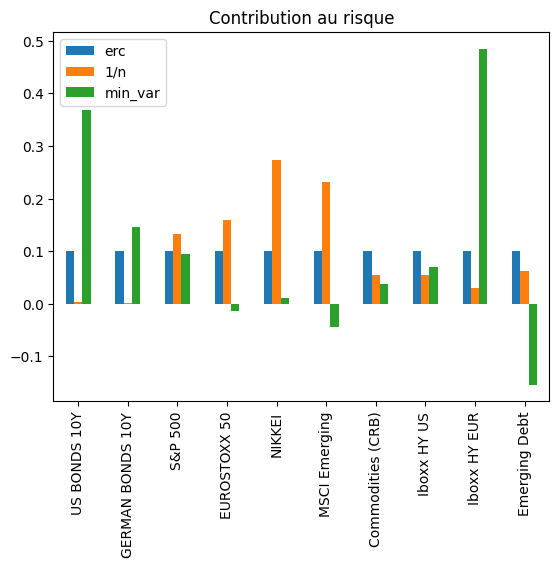

In [ ]:
def computeERC(Sigma):
      Sigma = np.array(Sigma)
      n = np.shape(Sigma)[0]
 
      x0 = np.ones((n,1)) / n
      x = x0*10
      var = np.diag(Sigma)
      Sx = Sigma.dot(x)
      cvg = False
 
      while not cvg:
          for i in range(n):
              alpha = var[i];
              beta =  (Sx[i]-x[i]*var[i])[0];
 
              gamma_ = -1.0/n;
 
              x_tilde = (-beta + np.sqrt(beta**2 - 4*alpha*gamma_)) / (2*alpha);
              x_i = x[i];
 
              x[i] = x_tilde;
              Sx = Sigma.dot(x) 
 
          cvg = np.sum( (x/np.sum(x) - x0/np.sum(x0))**2 ) <= 1e-5;
          #print cvg
          x0 = x.copy()
 
      return x/x.sum()
      
#calcul de l'ERC (portefeuille Equal Risk Contribution)
x_erc = computeERC(cov)
#calcul des contribution au risque
rc = x_erc*(cov.dot(x_erc))
#on met en base 100 dans une dataframe
rc = pd.DataFrame(rc/rc.sum())
rc.columns = ['erc']


#idem pour le portefeuille 1/n
rc_1n = x_1n*(cov.dot(x_1n))
rc["1/n"] = pd.DataFrame(rc_1n/rc_1n.sum())
 

#idem pour le portefeuille min var
rc_mv = x_mv*(cov.dot(x_mv))
rc["min_var"] = pd.DataFrame(rc_mv/rc_mv.sum())
rc.index = mu_ann.index

#plot 
rc.plot(kind='bar',title='Contribution au risque')


# Gestion indicielle

## Gestion benchmarkée

La gestion indicelle est un type de gestion ou l'on doit **battre un benchmark ou alors le repliquer** le mieux possible. Si on prend un portefeuille $x$ et un benchmark $b$, on appelle l'erreur de réplication ( ou tracking error) l'écart suivant :

$$ \begin{array}{ccc}
e(t) &=& R_x(t)- R_b(t)\\
  &=&(x-b)^\top R(t)
\end{array}$$

On peut alors avoir la variance de la tracking error et la sur/sous performance moyenne :

$$ \begin{array}{ccc}
\mu(x|b) &=& (x-b)^\top \mu\\
\sigma^2(x|b) &=& (x-b)^\top \Sigma (x-b)
\end{array}$$

Ce sont exactement les memes formules que lorsque l'on regarde uniquement le portefeuille $x$ sauf que l'on regarde une difference de portefeuille.

On obtient également une mesure semblable au ratio de sharpe que l'on appelle le ratio d'information :

$$\theta(x|b) = \frac{\mu(x|b) }{\sigma(x|b) }  $$

Si on veut essayer de battre un indice on peut transformer le probleme de markowitz de la façon suivante :

\begin{eqnarray*}
x^{\star } &=&\arg \min \frac{1}{2}(x-b)^{\top }\Sigma (x-b) -\color{blue}{\phi \mu^\top (x-b)} \\
&\text{u.c.}&\left\{
\begin{array}{l}
x\in \mathcal{C} \\
\mathbf{1}^{\top }x=1 \\
x\geq \mathbf{0}
\end{array}
\right.  
\end{eqnarray*}

* Le programme reste quadratique.
* Le paramètre $\phi$ est l'aversion à la tracking error. 
    *  ce paramètre sert à controler le risque de tracking error.

*  En gestion indicielle on peut egalement vouloir répliquer un indice. Par exemple repliquer le S&P500 mais avec une contrainte sur le nombre d'actif dans le portefeuille : **technique de l'echantillonage**



Plusieurs techniques : 

 * Enlever les actifs les plus petits en poids les uns après les autres tant que la contrainte de TE est respectée (Backward stepwise selecton)
 * Partir du model vide et inclure les variable une a une (Forward stepwise selecton)


 * Utilisation de la norme $L_1$ : cette norme permet de "sparsifier" le programme de markowitz :
  $$\begin{eqnarray*}
  x^{\star } &=&\arg \min \frac{1}{2}(x-b)^{\top }\Sigma (x-b) + \color{blue}{\lambda \sum_i |x_i| }\\
  &\text{u.c.}&\left\{
  \begin{array}{l}
  x\in \mathcal{C} \\
  \mathbf{1}^{\top }x=1 \\
  x\geq \mathbf{0}
  \end{array}
  \right.  
  \end{eqnarray*}$$
 



---



# Applications en gestion quantitative

##Gestion benchmarkée: réplication d'indice à composantes cachées

### Définition

Parfois on peut vouloir répliquer un indice ou un fonds dont on ne connait pas les expositions. Typiquement un indice représentatif de stratégie hedge funds.

<ipython-input-146-f2fabe5d1f68>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data = pd.read_csv(r"https://raw.githubusercontent.com/jcr-lyxor/DIFIQ/master/data/Exercice7TREX.csv",parse_dates=True,header=0,index_col=0,sep=";").loc["2009":].astype(float)
<ipython-input-146-f2fabe5d1f68>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  assets = data.drop(" HF Index ",1)


<Axes: title={'center': 'HF Index '}, xlabel=' Dates '>

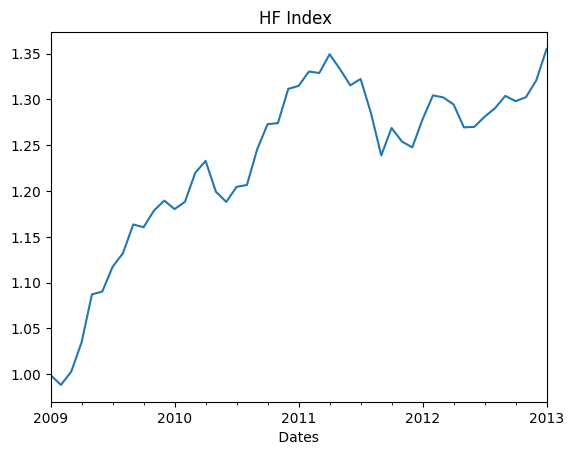

In [ ]:
data = pd.read_csv(r"https://raw.githubusercontent.com/jcr-lyxor/DIFIQ/master/data/Exercice7TREX.csv",parse_dates=True,header=0,index_col=0,sep=";").loc["2009":].astype(float)
hf =  data[" HF Index "] 
assets = data.drop(" HF Index ",1)
(hf+1).cumprod().plot(  title = "HF Index ")
 

On va supposer que le rendement de cet indice s'écrit comme une combinason lineaire d'actifs investissables :

$$R_I(t) = \sum_{i\in \mathcal{I}} \beta_i R_i(t) +\epsilon_t$$

Ou $\mathcal{I}$ est l'univers d'investissement à priori et $\epsilon_t$ un bruit gaussien de moyenne nulle et d'écart type $\sigma_{\epsilon}$. 
Dans ce cas on peut réécrire le problème comme la minimisation de tracking error. En effet on a :

$$ \begin{array}{ccc}
 e(t) &=& R_I(t)-  \sum_{i\in \mathcal{I}} \beta^\star_i R_i(t)  
\end{array}$$


On peut egalement écrire $\bar{R} = [R_I,R]$, $\bar{x} = [0,x^\top]$ et $b=[1,0_n^\top]$ ou $0_n$ est un vecteur de 0 de taille $n$. Le problème devient alors:
  $$\begin{eqnarray*}
  x^{\star } &=&\arg \min \frac{1}{2}(\bar{x}-b)^{\top }\Sigma (\bar{x}-b) \\
  &\text{u.c.}&\left.
  \bar{x}_0=0
  \right.  
  \end{eqnarray*}$$
et $\Sigma =\bar{R}^\top\bar{R} $.

**Plus simplement** ici, minimiser la variance de la tracking error revient alors a un problème de **régression lineaire** pour trouver les **$\beta_i$**.
 En écrivant $y = R_I(t)$ et $X = R$ la matrice des rendements de l'univers d'investissment on sait que $\hat{\beta}=(X^\top X)^{-1}X^\top
y$. On peut vérifier que les solutions sont identiques

> Les *betas* de la regression sont alors interprétés comme des poids d'un portefeuille. On peut donc investir ce portefeuille. D'autre methodes comme le filtre de Kalman peuvent etre appliqué. Voir par exemple [ce papier](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1035521).







 

### Exercice

Calculer la stratégie de réplication de l'indice et la tracking error. Comment améliorer ? 

Matrice de correlation


,HF Index,repliquant
HF Index,1.000000,0.894433
repliquant,0.894433,1.000000


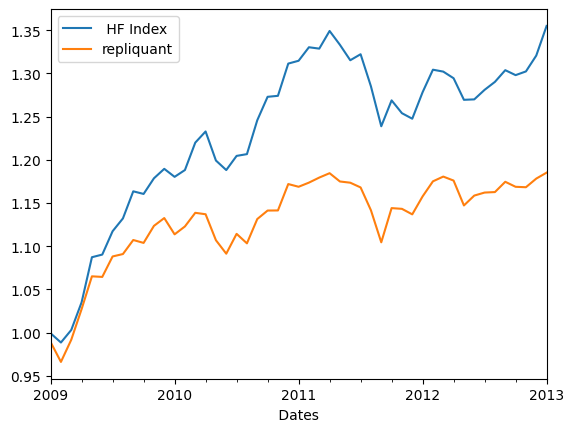

In [ ]:
eonia_ = pd.read_csv(r"https://raw.githubusercontent.com/jcr-lyxor/DIFIQ/master/data/eonia.csv",sep=";",index_col=0, parse_dates=True,infer_datetime_format=True) 
eonia_ = eonia_.reindex(hf.index)
eonia_ = eonia_.loc[hf.index,:]

#calcul du pas de temps
dt = pd.DataFrame(eonia_.index[1:].values-eonia_.index[:-1].values,columns=["dt"])

#calcul du rendement de eonia, vaut 0 en date 0
r_eonia_ =  np.array(eonia_['EONIA Index'])*( np.hstack((dt["dt"].shift(-1).dt.days/365,1/365)))
r_eonia_ = np.nan_to_num(r_eonia_)

y = hf.values
X = assets.values

betas = np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))

track  = pd.DataFrame((hf+1).cumprod())
track["repliquant"] = (X.dot(betas)  +r_eonia_+1).cumprod()
track.plot()
print('Matrice de correlation')
track.pct_change().corr()

In [ ]:
return_track = track/track.shift()-1
e = return_track[' HF Index ']-return_track['repliquant']
e.std()*252**0.5

0.12398792204949928

### Extension avec la regression Lasso



La régression LASSO s'écrit comme:
$$\beta^{\star } =\arg \min \frac{1}{2}(y-X\beta)^{\top }(y-X\beta) + \color{blue}{\lambda \sum_i |\beta_i| }$$

En faisant varier le parametre $\lambda$ on peut obtenir des solutions plus ou moins sparse c'est à dire faire de la selection d'actifs.


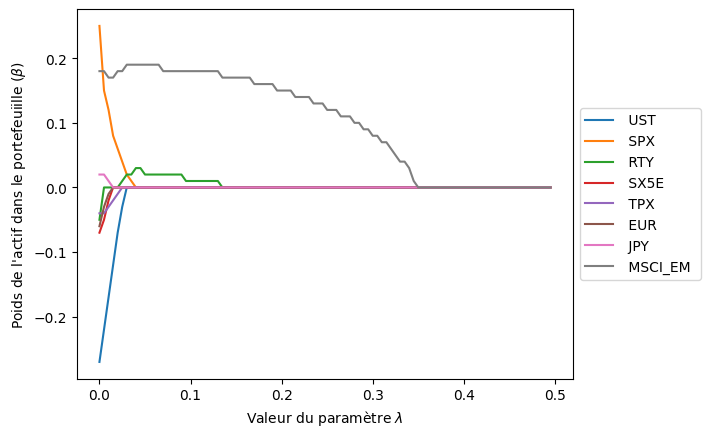

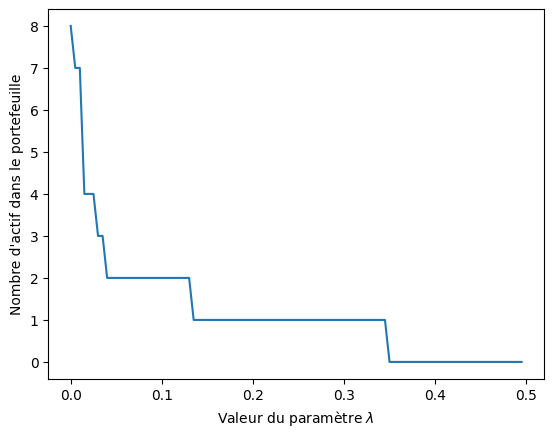

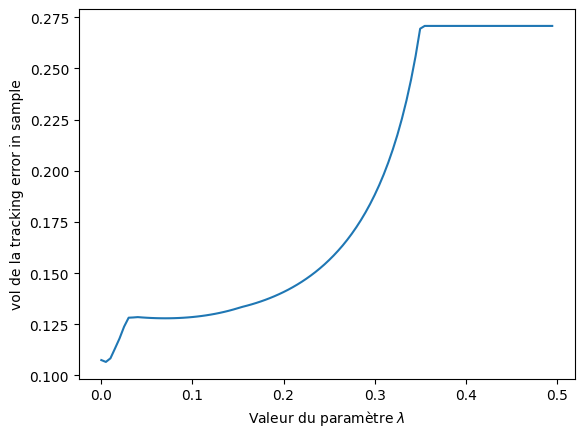

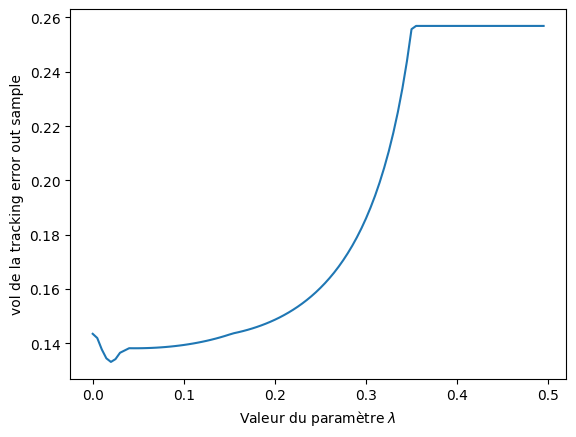

In [ ]:
#Allocate variables
beta = cp.Variable(8)
 

# Form objective.
error = y[:25]-X[:25,:]@beta

# Form penalty
langrangian = 1.0
penalty = cp.norm1(beta)

# Form and solve problem for a set of lagragians
solutions = {}
tracking_error_in_sample = {}
tracking_error_out_sample = {}
from matplotlib import rc
for langrangian in range(100):
  obj = cp.Minimize(cp.norm2(error)+penalty*langrangian/200)

  prob = cp.Problem(obj)
  prob.solve()

  solutions[langrangian/200] = pd.Series(beta.value.copy(),index=assets.columns).round(2)
  tracking_error_in_sample[langrangian/200] = np.std((y[:25]-X[:25,:]@beta.value))*260**0.5
  tracking_error_out_sample[langrangian/200] = np.std((y[25:]-X[25:,:]@beta.value))*260**0.5

ax=pd.DataFrame(solutions).T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
_=ax.set_xlabel(r'Valeur du paramètre $\lambda$')
_=ax.set_ylabel(r"Poids de l'actif dans le portefeuiille ($\beta$) ")

plt.figure()

ax=(pd.DataFrame(solutions).T.abs()>=1e-3).sum(1).plot(legend=False)
_=ax.set_xlabel(r'Valeur du paramètre $\lambda$')
_=ax.set_ylabel(r"Nombre d'actif dans le portefeuille")

plt.figure()

ax=pd.Series(tracking_error_in_sample) .plot(legend=False)
_=ax.set_xlabel(r'Valeur du paramètre $\lambda$')
_=ax.set_ylabel(r"vol de la tracking error in sample")

plt.figure()

ax=pd.Series(tracking_error_out_sample) .plot(legend=False)
_=ax.set_xlabel(r'Valeur du paramètre $\lambda$')
_=ax.set_ylabel(r"vol de la tracking error out sample")

le nombre de futures optimaux serait de 4:

In [ ]:
best_lagrangian = pd.Series(tracking_error_out_sample).idxmin()
pd.DataFrame(solutions).T.loc[best_lagrangian]

 UST        -0.07
 SPX         0.06
 RTY         0.00
 SX5E       -0.00
 TPX        -0.01
 EUR        -0.00
 JPY         0.00
 MSCI_EM     0.18
Name: 0.02, dtype: float64

## Smart beta: utilisation de l'ACP pour regulariser le portefeuille

### Definition

* On utilise beaucoup l'ACP en gestion quant car c'est un outils très puissant et simple. 


* Facilement interpretable par des portefeuilles. 


On va d'abord comprendre visuellement ce que fait l'analyse en composantes principales. Pour cela on prend un ensemble de point distribués normalement $(x,y)\sim \mathcal{N}(\mu,\Sigma)$ avec une certaine correlation. On a donc un ensemble de point $D$ :

$$D =  \left(\begin{array}{cc}
x_{1} & y_{1}\\
x_{2} & y_{2}\\
x_{3} & y_{3}\\
\vdots & \vdots\\
x_{n} & y_{n}
\end{array}\right)$$



 Mathématiquement on trouve les axes et la variance en diagonalisant la matrice de variance covariance de l'univers de point, ici $\Sigma$.
  


La décomposition s'ecrit:

$$  {\Sigma}=V\Lambda V^\top{}$$


ou les valeurs propres sont dans la matrice diagonale $\Lambda = \mathrm{diag}\left(\lambda_{1},\cdots,\lambda_{n}\right)$ avec $\lambda_1>\lambda_2>\cdots >\lambda_n$ et la matrice des vecteurs propres $V$ est telle que $V^\top V=I$.

On peut aussi écrire la décomposition comme :

$$\Sigma= \sum_i \lambda_i v_i v_i^\top{} $$


Les coordonnées des points dans le nouveau $\tilde{D}$ repère sont données par :

$${D} =  \left(\begin{array}{cc}
x_{1} & y_{1}\\
x_{2} & y_{2}\\
x_{3} & y_{3}\\
\vdots & \vdots\\
x_{n} & y_{n}
\end{array}\right) =>\tilde{D}= \left(\begin{array}{cc}
x_{1}v_{1,1} + y_{1}v_{1,2} & x_{1}v_{2,1} +y_{1}v_{2,2} \\
\vdots & \vdots\\
\vdots & \vdots\\
\vdots & \vdots\\
x_{n}v_{1,1} + y_{n}v_{1,2} & x_{n}v_{2,1} +y_{n}v_{2,2}
\end{array}\right) $$

On graphe les points dans un plan :

In [ ]:
correlation = 0.8
import matplotlib.pyplot as plt

@interact(correlation=(-1,1,0.1),scale=False)
def plot_correlation(correlation,scale):
  mean=(0,0)
  points = pd.DataFrame(np.random.multivariate_normal(
              mean=mean, cov=[[1, correlation],[correlation, 1]], size=10000
              ),columns=["x","y"])
  _=points.plot(kind='scatter',x='x',y="y",title='original space' )
  _.set_ylim(-5, 5)
  _.set_xlim(-5, 5)
  _=plt.figure()

  V, L, Vt = np.linalg.svd([[1, correlation],[correlation, 1]],full_matrices=True)
  
  V = np.round(V,2)
  if scale:
    Factor = (points.dot( V ).dot(np.diag(L**(-0.5)))).values
  else:
    Factor = (points.dot( V )).values

  Factor = pd.DataFrame(Factor,columns=[f"x factor 1: {V[0,0]}x+{V[1,0]}y",f"y factor 2: {V[0,1]}x+{V[1,1]}y"])
  _=Factor.plot(kind='scatter',x=Factor.columns[0],y=Factor.columns[1],color='tab:green',title=f'pca factor space: eigenvalue = {L}' )
  _.set_ylim(-5, 5)
  _.set_xlim(-5, 5)
  _=plt.figure()
  plt.show()

interactive(children=(FloatSlider(value=0.0, description='correlation', max=1.0, min=-1.0), Checkbox(value=Fal…

Pour des applications financières on va plutot prendre **les rendements des actifs**. Pour cela on va utiliser la decompostion de la matrice de varcovar.
La matrice de variance covariance peut être estimée par 

$$\hat{\Sigma} = R^\top R / p $$

ou $p$ est le nombre de jour et $R$ la matrice des rendements(par exemple de taille 260 jours en ligne et 10 actifs en colonne). On obtient alors en python :  



In [ ]:
#on calcule la covariance annualisee
R = R.tail(260)
p = R.index.size
cov = R.T.dot(R) / p * 260

  * Les vecteurs propres : donne le vecteur (et donc la direction) sur lequel est representée l'information. Danc notre application financière **c'est un portefeuille**.
  
* Les valeurs propres : c'est information. Dans notre application financière **c'est la variance** des portefeuille propres.
 
 


**Rapprochement avec l'optimisation de portefeuille**: Pour trouver la plus grande variance (ou valeur propre) on va donc maximiser la variance d'un vecteur (d'un portefeuille $v_1$) :
    
\begin{eqnarray*}
\lambda_1 &=&\ \max  v_1^{\top }\Sigma v_1  \\
&\text{u.c.}& {v_1}^{\top }v_1=1  
\end{eqnarray*}
    
Ensuite on enleve toute "l'information" du premier vecteur de la matrice de covariance et on recommence pour trouver $v_2$.


$$
\begin{eqnarray*}
\lambda_2 &=&\ \max  v_2^{\top }\left(\Sigma-\lambda_1v_1{v_1}^{\top }\right) v_2  \\
&\text{u.c.}& {v_2}^{\top }v_2=1 
\end{eqnarray*}
$$

On pourrait aussi resoudre:
\begin{eqnarray*}
\lambda_2 &=&\ \max  v_2^{\top }\Sigma v_2  \\
&\text{u.c.}& {v_2}^{\top }v_2=1  \\
& & {v_2}^{\top }v_1=0  \\
\end{eqnarray*}
et ainsi de suite.

> L'ACP sur une matrice de rendement revient **a trouver les porteufeilles de norme 1** qui **maximisent la variance** sous la contrainte d'etre **correles a 0**.



A noter que:
  * il y a autant de facteur que de nombre d'actif quand la matrice de covariance est bien définie positive.
  

  * Les portefeuilles propres de sont donnés par $\mathcal{F}=V \Lambda^{-1/2}$ et ont pour variance $I$ 
  

Exmple sur notre univers multi-asset

In [ ]:
#on utilise singular value decomposition / décomposition valeur propre vecteurs propres
V, L, Vt = np.linalg.svd(cov,full_matrices=True)
V = pd.DataFrame(data = V,index=cov.columns.values) 
V.columns = ["Vec. Prore "+str(x) for x in range(1,11)]
L = pd.DataFrame(data = L,index=V.columns.values,columns=["Valeur Propre"]) 

<Axes: >

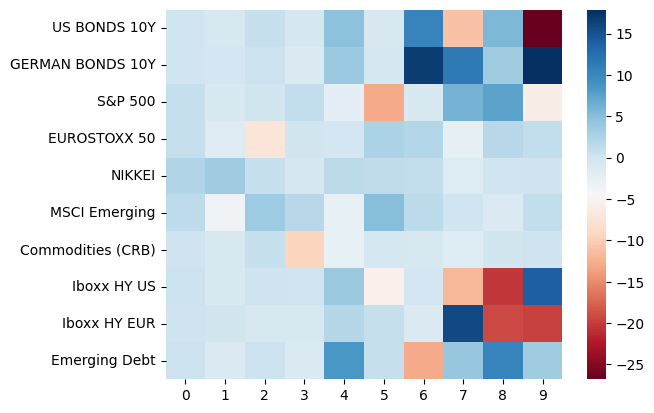

In [ ]:
Lambda = L["Valeur Propre"]
inv_sqrt_Lambda=np.diag(Lambda.pow(-0.5))
w_f =  V.dot(inv_sqrt_Lambda) 
sns.heatmap (w_f,cmap="RdBu")

In [ ]:
1/Lambda

Vec. Prore 1        9.069360
Vec. Prore 2       29.989082
Vec. Prore 3       69.428950
Vec. Prore 4       95.107121
Vec. Prore 5      148.095215
Vec. Prore 6      234.009178
Vec. Prore 7      563.521286
Vec. Prore 8      707.562319
Vec. Prore 9      997.476314
Vec. Prore 10    1672.761159
Name: Valeur Propre, dtype: float64

### Application en Gestion de portefeuille

**Shrinkage des expected returns**

Dans la pluplart des methodes de gestions de portefeuille ,c'est **l'inverse de la matrice de variance covariance qui intervient** dans la solution.
L'inverse de la matrice de variance covariance admet la même décomposition avec **des valeurs propres inverses** et les **mêmes vecteurs propres** :


$$ \hat{\Sigma}^{-1}=V\Lambda^{-1} V^\top{}$$


> En conséquences, les facteurs à forte variance deviennent les moins importants et les facteurs à faible variance deviennent importants. En effet, on cherche souvent a minimiser la variance du portefeuille et donc à être exposer à ces facteurs.







Les rendements des facteurs sont simplement donnés par $$\mathcal{F}_t =   R_t V \Lambda^{-1/2}  $$


On voit bien alors que la matrice de variance covariance des facteurs est l'identité:


 \begin{eqnarray}
\mathcal{F}_t^\top \mathcal{F}_t &=&   \Lambda^{-1/2} V^{\top} R_t^\top  R_t V \Lambda^{-1/2} \\ 
  &=&    \Lambda^{-1/2} V^{\top} V\Lambda V^\top{} V \Lambda^{-1/2} \\
&=&    \Lambda^{-1/2}  \Lambda   \Lambda^{-1/2} \\
&=& I
\end{eqnarray}


On peut vérifier:

In [ ]:
w_f

,0,1,2,3,4,5,6,7,8,9
US BONDS 10Y,-0.076173,-0.670966,0.718185,-0.585945,4.660131,-0.638800,10.404411,-11.027097,5.629895,-26.794466
GERMAN BONDS 10Y,-0.070953,-0.343148,0.343318,-0.988210,3.800841,-0.531103,16.683747,11.532774,3.407211,17.885798
S&P 500,0.857967,-0.936527,-0.189614,0.970618,-2.226367,-12.930861,-0.847829,6.035315,7.531403,-6.002951
EUROSTOXX 50,0.920053,-1.531963,-7.353935,-0.190996,-0.366723,2.603105,2.051051,-2.396931,1.700714,1.113247
NIKKEI,2.283197,3.411437,0.715932,-0.457939,1.587664,1.170569,1.068455,-1.364832,-0.074839,0.128799
MSCI Emerging,1.434793,-3.424075,3.616913,1.780115,-2.660751,4.977092,1.572257,-0.026248,-1.297563,0.986811
Commodities (CRB),0.201087,-0.644264,0.700894,-9.369814,-2.626511,-0.573036,-0.692344,-1.361975,-0.166271,0.257355
Iboxx HY US,0.260047,-0.929727,0.147553,0.002625,3.909862,-5.594211,-0.300195,-11.835726,-20.287056,13.911790
Iboxx HY EUR,0.149767,-0.228043,-0.655125,-0.633246,1.848142,0.918559,-1.021285,15.784889,-19.234250,-19.777711
Emerging Debt,0.271681,-1.226164,0.377015,-1.111629,8.464002,0.852495,-12.913962,4.221933,10.550788,3.448024


In [ ]:
w_f =  (V).dot(inv_sqrt_Lambda) 
w_f.columns= ['factor '+str(x+1) for x in range(10)]
F = (R.dot(w_f)  )
(F.T.dot(F)).round(1)


,factor 1,factor 2,factor 3,factor 4,factor 5,factor 6,factor 7,factor 8,factor 9,factor 10
factor 1,1.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
factor 2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
factor 3,0.0,0.0,1.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0
factor 4,0.0,0.0,-0.0,1.0,0.0,0.0,-0.0,0.0,0.0,0.0
factor 5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.0,-0.0,-0.0
factor 6,-0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.0,-0.0
factor 7,0.0,0.0,-0.0,-0.0,0.0,0.0,1.0,-0.0,-0.0,0.0
factor 8,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,1.0,-0.0,-0.0
factor 9,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,1.0,0.0
factor 10,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,1.0


* Les facteurs sont des stratégies non corrélées les unes aux autres
* les vecteurs propres sont intéprétés comme des portefeuilles 
  *  On les appelle les portefeuilles propres.
* C'est une façon de voir un univers en stratégie indépendantes.




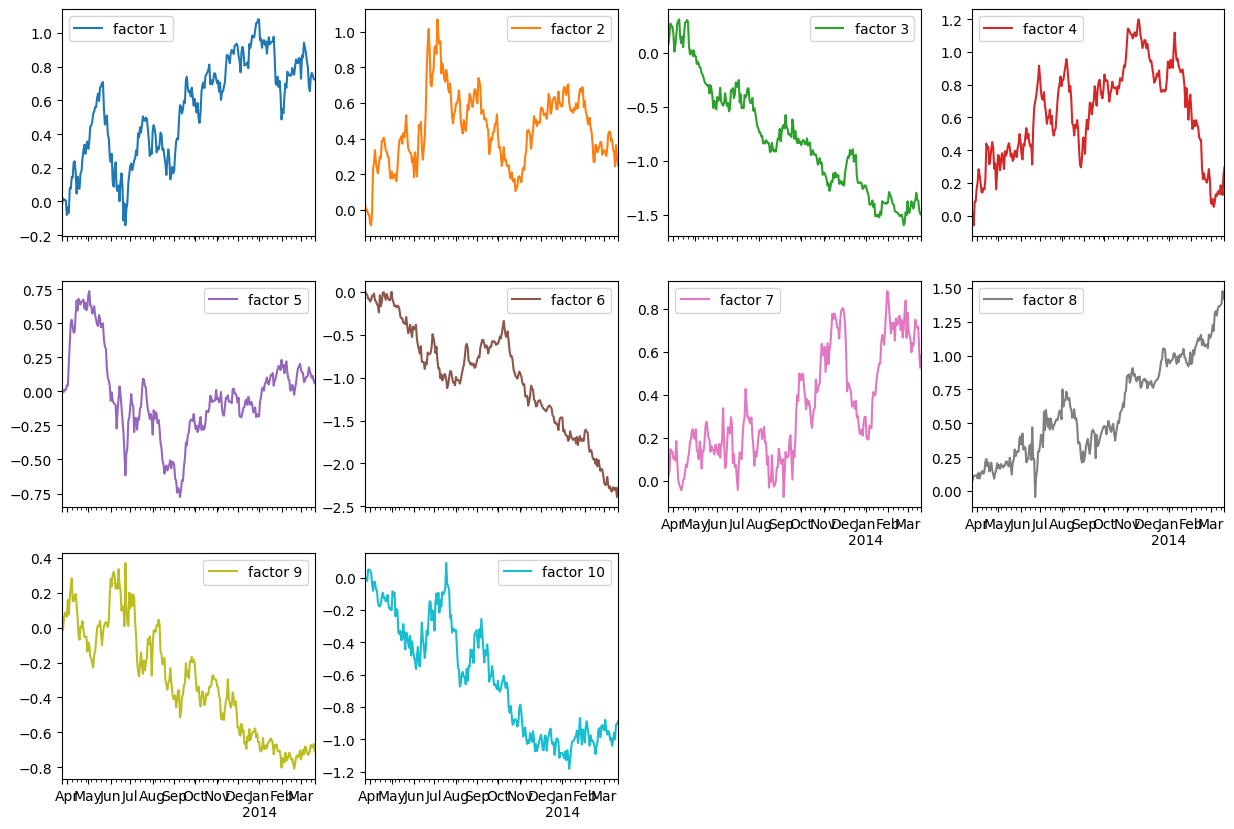

In [ ]:
factor = pd.DataFrame(np.array((F).cumsum()),columns=['factor '+str(x+1) for x in range(10)],index = F.index)
_=factor.plot(subplots=True,figsize=(15,10),layout =(3,4))

On peut alors calculer le rendement attendu et le Sharpe attendu des ces facteurs. 

In [ ]:
mu = R.mean(0)*260
mu_factor = w_f.T@mu
factor_sharpe = mu_factor/(F.std()*260**0.5)
factor_sharpe

factor 1     0.723064
factor 2     0.251074
factor 3    -1.505763
factor 4     0.294200
factor 5     0.059774
factor 6    -2.301027
factor 7     0.580356
factor 8     1.417845
factor 9    -0.709333
factor 10   -0.891218
dtype: float64

Il y a un intérêt dans la gestion de portefeuille. Si on reprend le probleme de markowitz, on peut exprimer les poids à l'aide des facteurs :


\begin{eqnarray}
x^\star &=& \phi\Sigma^{-1}\mu\\ 
  &=&   \phi V\Lambda^{-1} V^\top{}\mu
\end{eqnarray}


Si on investit le portefeuille, les rendements du portefeuille sont donnés par:


\begin{eqnarray}
r_t^p &=& r_t^\top x^\star\\ 
  &=&    r_t^\top  V\Lambda^{-1} V^\top{}\mu \phi \\
  &=&     r_t^\top  V\Lambda^{-1/2}\Lambda^{-1/2} V^\top{}\mu \phi\\
  &=&    (r_t^\top  V\Lambda^{-1/2}) (\Lambda^{-1/2} V^\top{}\mu \phi)
\end{eqnarray}

* On voit alors que le rendement du facteur apparait :
  
  $$f_t  = r_t^\top  V\Lambda^{-1/2}$$ 


    
* Ainsi que les poids $z$ dans les facteurs :

$$ z  = \Lambda^{-1/2} V^\top{}\mu \phi $$ 

* On a donc la relation :

\begin{eqnarray}
x^\star &=&  V\Lambda^{-1/2} z 
\end{eqnarray}







Les rendemements du portefeuille peuvent s'écrire $$ r_t^p  =  f_t^\top z  $$:
On voit ici que les rendements du portefeuille peuvent être vus comme les rendements d'un investissement dans les actifs mais aussi dans les facteurs. 





On peut utiliser cette décoposition pour regulariser l'allocation sur certains facteurs.

Puisque les facteurs ont la même variance égale à 1, leur ratio de Sharpe est directement proportionel au rendement attendu 

$$\mu_f = \theta_f=\Lambda^{-1/2} V^\top{}\mu$$

Si l'on veut réduire l'exposition de notre portefeuille à un facteur, une solution est de **shrinker** le rendement attendu de ce facteur puis en déduire le rendement attendu des actifs. Par exemple on peut limiter le Sharpe attendu dans chaque facteur:

In [ ]:
mu = R.mean(0)*260
mu_factor = w_f.T@mu
mu_factor_shrinked = np.maximum(np.minimum(mu_factor,1),-1)
mu_f= pd.DataFrame( mu_factor,columns=['mu_factor'])
mu_f['mu_factor_shrinked'] = mu_factor_shrinked
mu_f


,mu_factor,mu_factor_shrinked
factor 1,0.723729,0.723729
factor 2,0.251527,0.251527
factor 3,-1.502106,-1.000000
factor 4,0.294719,0.294719
factor 5,0.059889,0.059889
factor 6,-2.282255,-1.000000
factor 7,0.581098,0.581098
factor 8,1.415099,1.000000
factor 9,-0.710012,-0.710012
factor 10,-0.891571,-0.891571


In [ ]:
mu_assets= pd.DataFrame(V@np.diagflat(Lambda.values)**0.5@mu_factor_shrinked.values,columns=['mu_asset_shrinked'])
mu_assets['mu_assets'] = mu
mu_assets

,mu_asset_shrinked,mu_assets
US BONDS 10Y,-0.013834,-0.021996
GERMAN BONDS 10Y,0.008804,0.015998
S&P 500,0.126201,0.201967
EUROSTOXX 50,0.151550,0.189064
NIKKEI,0.193877,0.181484
MSCI Emerging,0.018835,-0.034610
Commodities (CRB),-0.029758,-0.032486
Iboxx HY US,0.026312,0.048955
Iboxx HY EUR,0.059823,0.068787
Emerging Debt,-0.014397,-0.019318


**Contrainte factorielle**

La PCA peut etre aussi directement utilisee dans une optimisation. Par exemple on peut vouloir etre neutre a un ou plusieurs facteurs. Il suffit de rajouter la contrainte:

In [ ]:
#Allocate variables
x = cp.Variable(10)
 
# Form objective.
mu_ptf = x.T@mu
obj = cp.Maximize(mu_ptf)

V, L, Vt = np.linalg.svd(cov,full_matrices=True)# columns of V are the pca factors


# Form constraints
var_ptf = cp.quad_form(x,cov*260)
constraints = [ var_ptf<=0.1**2,
               cp.sum(x)==0,
               V[:,[0]].T@x==0
               ]


# Form and solve problem.
prob = cp.Problem(obj, constraints)
prob.solve()

print(f'La volatilité ann. du portefeuille est {100*np.round(var_ptf.value**0.5,2)}%\
      ,\n le rendement ann. attendu {100*np.round(mu_ptf.value,2)}% \
      ,\n la containte vs PCA1 vaut {np.round((V[:,0]@x).value,2)} \
      ,\n le Sharpe attendu {np.round(mu_ptf.value,2)/np.round(var_ptf.value**0.5,2)}')

La volatilité ann. du portefeuille est 10.0%      ,
 le rendement ann. attendu 2.0%       ,
 la containte vs PCA1 vaut -0.0       ,
 le Sharpe attendu 0.19999999999999998


 ## Smart beta: backtest d'une strategie minimum variance

### Exemple

Le backtest d'une stratégie permet de simuler dans le passé une allocation de portefeuille ou une idée de trading. De façon simplifié les étapes sont:


1.   Avoir un univers d'investissements et le rendement des actifs.
2.   Calculé les poids/les positions dans chancun des actifs en utilisant les données passées à chaque date.
3.   "Investir" les positions dans les rendement et generé les rendements du portefeuille. Généralement à cette étape on tient compte de tout les frais: management, couts de transactions, ...


     
     


Voici un backtest typique de stratégie:




In [ ]:
              
# récupère les dates et les rende;ents des actifs
import pandas as pd
import numpy as np

data = pd.read_csv(r"https://raw.githubusercontent.com/jcr-lyxor/DIFIQ/master/data/data.csv",sep=";",index_col=0,  parse_dates=True,infer_datetime_format=True)
R = data / data.shift()-1
R = R.fillna(0)
 
dates = R.index.values
nDates = dates.size
n = len(R.columns)


# préparation des matrices de poids nbDates x nbAssets
X_mv = pd.DataFrame(index=data.index, columns=data.columns)
X_1n = pd.DataFrame(index=data.index, columns=data.columns)
X_mvo = pd.DataFrame(index=data.index, columns=data.columns)

# préparation du backtest MV et 1n
backtest = pd.DataFrame(index=data.index, columns=["MV","1n"]) 

# initialisation à 1 (100%)
backtest["MV"].iloc[0] = 1
backtest["1n"].iloc[0] = 1

#le lag est la taille de la fenetre de calcul
lag = 260

# on parcours les dates
for t, d in enumerate(dates):
    
    # si on a pas de données on reste à 1
    if t<lag+1:
        backtest["MV"].loc[d] = 1
        backtest["1n"].loc[d] = 1
        continue
    
    #recupère les rendement des actifs sur les 260 derniers jours
    R_t = R.iloc[t-lag:t,:]
    
    #calcul de la matrice de covariance
    cov_t = R_t.cov() * 260
    
    #calcul de l'inverse
    inv_cov = np.linalg.inv(cov_t)
    
    #calcul du lambda optimal pour avoir somme des poids = 1
    lbda = 1/inv_cov.sum().sum()
    
    
    #calcul de l'allocation
    X_mv.loc[d] =  lbda * inv_cov.dot(np.ones(n))
    
    #calcul de la performance
    r_mv = np.nan_to_num(R.iloc[t,:].dot(X_mv.iloc[t-1]))


    
    #cumul de la valeur du portefeuille
    backtest["MV"].loc[d] =  backtest["MV"].iloc[t-1]*(1+r_mv)
    
    X_1n.loc[d] = np.ones((1,n)) / n
    backtest["1n"].loc[d] =  backtest["1n"].iloc[t-1]*(1+np.nan_to_num(R.iloc[t,:].dot(X_1n.iloc[t-1])))



<Axes: >

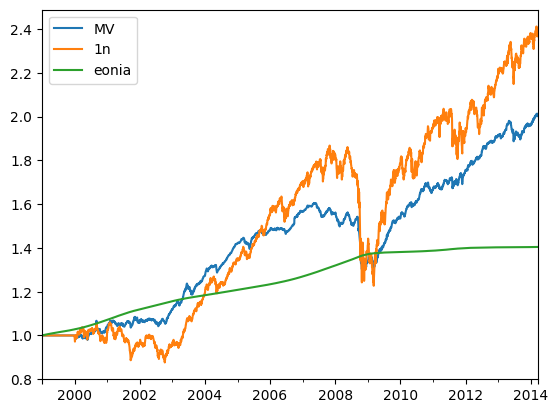

In [ ]:
backtest["eonia"] = eonia_cap
backtest.plot()

In [ ]:
#on voit que la volatilité sur min var est beacoup plus faible.
backtest.pct_change().std()*260**0.5

MV       0.033312
1n       0.089795
eonia    0.001325
dtype: float64

### Les dangers du backesting

**Survivorship bias**: un bias que l'on retrouve souvent sur les stratégies actions. Par exemple vous définissez votre univers comme étant le S&P500 aujourd'hui et commencez à faire des backtests. Ici l'erreur c'est que les composantes du S&P500 aujourd'hui changent dans le temps et vous n'en tennez pas compte.


**Look-ahead bias**: utiliser de l'information future pour établir les position aujourd'hui. Cela peut aussi bien être sur un expected return, un calcul de vol, une information non disponible, ...

Voici un exemple de ce biais sur le vol target que de la stratégie 1/n vue en début de cours:

<Axes: >

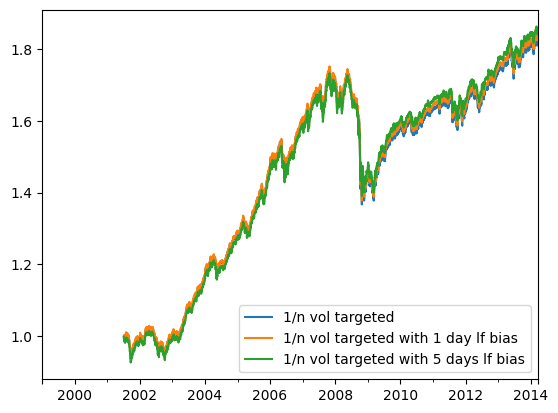

In [ ]:
r_strategy = (1+fraction_a_investir.shift()*rendements_1_sur_n + (1-fraction_a_investir.shift())*r_eonia.iloc[:,0].values).cumprod()
r_strategy_with_lf_bias_1_day = (1+fraction_a_investir.shift(0)*rendements_1_sur_n + (1-fraction_a_investir.shift(0))*r_eonia.iloc[:,0].values).cumprod()
r_strategy_with_lf_bias_5_days = (1+fraction_a_investir.shift(-5)*rendements_1_sur_n + (1-fraction_a_investir.shift(-5))*r_eonia.iloc[:,0].values).cumprod()
pd.DataFrame({"1/n vol targeted":r_strategy,"1/n vol targeted with 1 day lf bias":r_strategy_with_lf_bias_1_day
              ,"1/n vol targeted with 5 days lf bias":r_strategy_with_lf_bias_5_days}).plot()

**Overfitting/ data-snooping bias:** lorsque l'on optimise sur nos donnée in-sample, c'est à dire que l'on découvre des stratégies à force d'utiliser nos données, augmenter le nombre de paramêtre. Par exemple on peut simuler des variables aléatoires et en trouver une combinaison linéaire qui performe (**in-sample**) avec un allocation de Mean Variance par exemple.

Si de nouvelles données (**out sample**) on se rend compte que la stratégie ne fonctionne pas du tout.

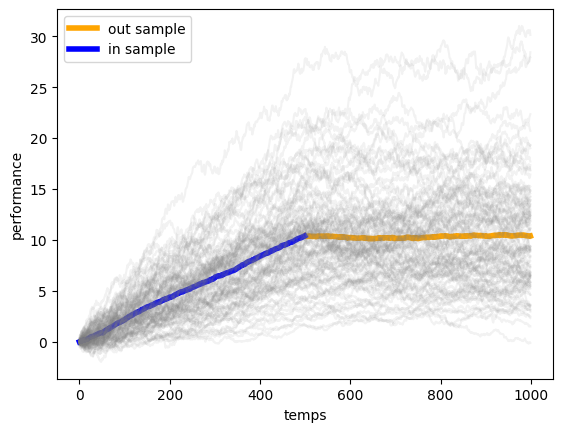

In [ ]:
n_simulations = 100
in_sample_size = 500
vol = 0.1/260**0.5
n_observations = 1000
n_assets = 10

simuls = {}
for s in range(n_simulations):
  #simulation of random noise 
  returns = pd.DataFrame(np.random.normal(scale=vol,
                                          size=n_observations*n_assets   
                                          ).reshape((n_observations,n_assets)) )
  mu = returns.iloc[:in_sample_size,:].mean(0)
  cov  = returns.iloc[:in_sample_size,:].cov()

  x = np.linalg.inv(cov)@mu

  simuls[s] = (returns@x).cumsum() 
  
simuls_mean = pd.DataFrame(simuls).mean(1)
simuls_mean.iloc[in_sample_size:].rename('out sample').plot(legend=True,color=['orange'],linewidth=4  )

ax=simuls_mean.iloc[:in_sample_size].rename('in sample').plot(legend=True,color='blue',linewidth=4 )
pd.DataFrame(simuls).plot(legend=False , color='grey',ax=ax,alpha=0.1)

_=ax.set_xlabel("temps")
_=ax.set_ylabel("performance")

##Smart beta: Modern trend following 

Pour finir voici une introduction à la modernisation des stratégies avec des technniques récentes de Machine Learning. La recherche est encore très actives et je ne présente ici qu'une toute petite partie.

### Approche pénalisée du portefeuille moyenne variance

Le suivi de tendance est une strategie de hedge fund très connu depuis plusieurs decenies. 

Elle repose sur une hypothese de bias de marche : les investisseurs on tendance à acheter le marché quand il monte et le vendre quand il baisse créant un effet de tendance.

* Historiquement on utlisait des croisements de moyenne mobiles.
* Aujourd'hui on utilise des techniques plus modernes combinant Markowitz, l'optimisation convexe et la régularization.


Il existe une connection mathématique entre la regression linéaire et l'optimisation moyenne variance pour le trend following. 

En effet pour la regression lineaire on a le modele classique suivant:
 
  * $Y = X \beta + \varepsilon$
  
avec
  * $\hat { \beta } ^ { \mathrm { ols } } = \left( X ^ { \top } X \right) ^ { - 1 } X ^ { \top } Y$

Si on estime le modele de regression suivant :

$$\phi \mathbf { 1 } _ { n } = R x + \varepsilon$$

avec $R$ la matrice des rendements des actifs on obtient la solution OLS suivante :

$$
\begin{aligned} \hat { x } ^ { \mathrm { mvo } } & = \left( R ^ { \top } R \right) ^ { - 1 } R ^ { \top } \phi \mathbf { 1 } _ { n } \\ & = \phi \hat { \Sigma } ^ { - 1 } \hat { \mu } \end{aligned}
$$

On retrouve bien la solution de Markowitiz. On voit alors que l'estimateur de tendance est la moyenne passee des rendements.

En conséquence nous pouvons emprunter les même techniques de **régularisation/pénalisation**:
ridge regression, lasso regression, fused lasso...

En augmentant le probleme  de Markowitz on obtient un nouveau problème:
    
$$ x^{\star}(\phi, \lambda)=\arg \min \frac{1}{2} x^{\top} \hat{\Sigma} x-\phi x^{\top} \hat{\mu}+\frac{1}{2} \lambda P(x)$$
   
ou $P(x)$ est un term de pénalisation similaire à ce que l'on trouve en regression linéaire. On utilisera differentes normes chancune avec différentes propriétés et les combiner.



Les différentes normes sont facilement interprétables :
* $P(x) = |x|$: selection d'actif (equivalent LASSO)
* $P(x) = \|x\|^2_2$: shrinkage, aversion aux correlations (équivalent RIDGE)
* $P(x) = x_t^{\top} A x_t$: (generalised RIDGE)
* $P(x) = |x_t-x_{t-1}|$: sparse aversion aux rebalancements (1-norm)
* $P(x) = \|x_t-x_{t-1}\|^2_2$: smoothing aversion aux rebalancements (2-norm)
* $P(x) = (x_t-x_{t-1})^{\top} A (x_t-x_{t-1})$: smoothing aversion aux rebalancements généralisée (generalised 2-norm)

Un exemple en utilisant la norme generalised RIDGE:

$$ x^{\star}(\phi, \lambda)=\arg \min \frac{1}{2} x^{\top} \hat{\Sigma} x-\phi x^{\top} \hat{\mu}+\frac{1}{2} \lambda x^{\top} A x$$

ou $A$ est par exemple la matrice diagonale des variance des actifs. Dans ce cas la solution optimale est:

$$x^{\star}(\phi, \lambda)=\phi(\hat{\Sigma}+\lambda A)^{-1} \hat{\mu}$$


On voit alors que lorsque $\lambda \rightarrow +\infty$ on dégonfle les correlations jusqu'a ce qu'elles disparaissent. En jouant sur ce parametre nous pouvons jouer sur l'effet de correlation. Virtuellement **on diminue le nombre de paramêtres** et donc **on diminue le risque d'overfiting**.

On peut aussi combiner les contraintes. Par exemple nous pouvons combiner l'aversion a la correlation avec l'aversion aux rebalancement :

$$ x^{\star}(\phi, \lambda)=\arg \min \frac{1}{2} x^{\top} \hat{\Sigma} x-\phi x^{\top} \hat{\mu}+\frac{1}{2} \lambda x^{\top} A x +\frac{1}{2} \alpha (x-x_0)^{\top} A (x-x_0) $$



Dans ce cas la solution optimale est:

$$x^{\star}(\phi, \lambda,\alpha)=(\hat{\Sigma}+(\alpha + \lambda) A)^{-1} \left( \phi\hat{\mu} -\alpha A x_0\right)$$

Si on suppose que $A = \operatorname { diag } \left( \hat { \sigma } _ { 1 } ^ { 2 } , \ldots , \hat { \sigma } _ { n } ^ { 2 } \right)$ et que l'on est 100% averse aux correlations ($\lambda\rightarrow +\infty$), on obtient la solution par actif suivante :

$$x _ { i  } ^ { \star } ( \phi , \alpha ) \quad = \quad \frac { \phi } { \hat { \sigma } _ { i } ^ { 2 } + \alpha \hat { \sigma } _ { i } ^ { 2 } } \hat { \mu } _ { i  } + \frac { \alpha \hat { \sigma } _ { i } ^ { 2 } } { \hat { \sigma } _ { i } ^ { 2 } + \alpha \hat { \sigma } _ { i } ^ { 2 } } x _ 0$$

Si on rearrange les termes on peut reconnaitre que la soltuion est très proche d'une moyenne mobile exponentielle des solutions précédentes:
    
$$ x _ { i  } ^ { \star } ( \phi , \alpha )  = \nu x _ { i  } ^ { \star } ( \phi  )  + \left( 1-\nu\right) x _ { 0  }$$

avec $\nu = 1 / (1+\alpha)$ et $ x _ { i  } ^ { \star } ( \phi  ) $ la solution non pénalisée $$x _ { i  } ^ { \star } ( \phi , 0 ) \quad = \quad \frac { \phi } { \hat { \sigma } _ { i } ^ { 2 } } \hat { \mu } _ { i  } $$ Puisque le paramêtre de smoothing est entre 0 et 1, on remarque que l'on update la position  courrante $x_0$ d'une proportion de la nouvelle exposition optimale. Une étude plus approfondi se trouve dans [ce papier.](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2767358)

Cette exemple montre que l'on peut adapter des techniques du machine learning et en donner une interprétation en optimisation de portefeuille.

Exercice: backtest de la strategy en Excel

### Backtest de la stratégie

In [ ]:
data = pd.read_csv(r"https://raw.githubusercontent.com/jcr-lyxor/DIFIQ/master/data/data.csv",sep=";",index_col=0,  parse_dates=True,infer_datetime_format=True)

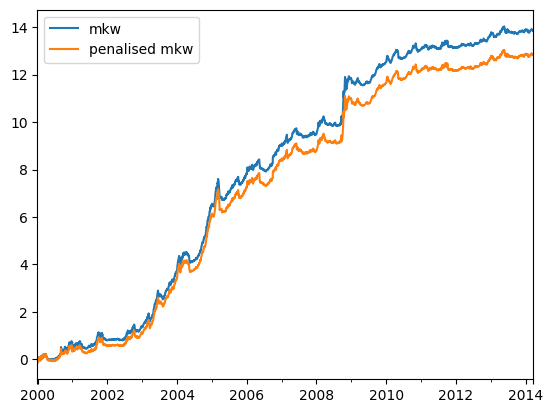

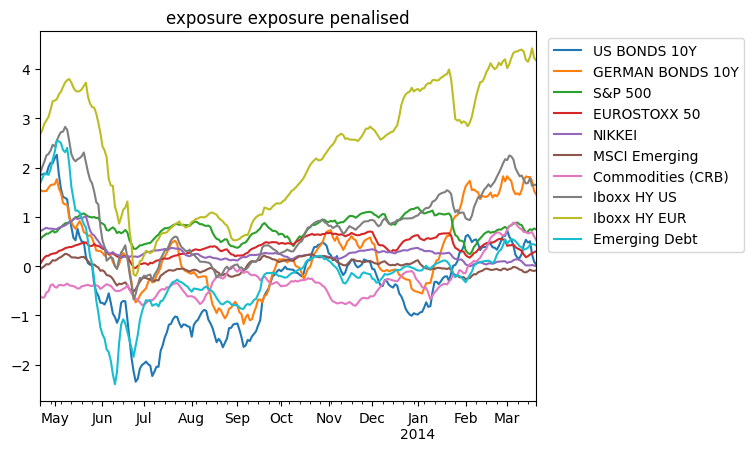

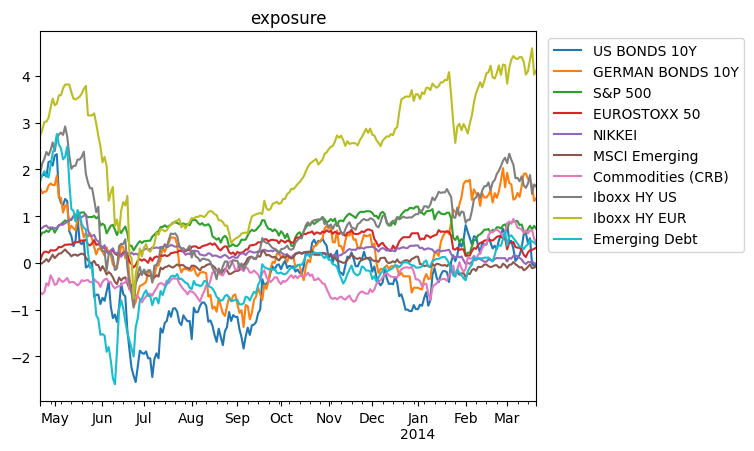

In [ ]:
halflife = 60 #halflife of mu and sigma estimate in number of days
halflife_allocation = 1 #halflife of the allocation in number of days (smoothing penalty)
phi=0.05# risk aversion, control the overall volatility


r = data.pct_change()
mu = r.ewm(halflife=halflife).mean()*260 #annualised
vol = r.ewm(halflife=halflife).std()*260**0.5 #annualised

w = mu/vol**2*phi 

w_smoothing = w.ewm(halflife=halflife_allocation).mean()

strategies = pd.DataFrame((w.shift().fillna(0)*r).iloc[260:,:].sum(1).cumsum(),columns = ['mkw'])
strategies["penalised mkw"]=(w_smoothing.shift().fillna(0)*r).iloc[260:,:].sum(1).cumsum()

strategies.plot()

(w_smoothing.tail(500).iloc[260:,:] ).plot(title="exposure exposure penalised")
lgd = plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
(w.tail(500).iloc[260:,:] ).plot(title="exposure")
lgd = plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

### Prise en compte des couts de transactions

La penalisation de turnover trouve son interet  lorsque l'on prend en compte les couts de transactions. Les couts de rebalancement d'un portefeuille peuvent aussi etre exprime en pourcentage et sont calcules comme:

$$T(t)=|c(x_t-x_{t-1})|_1$$

ou $c$ est le cout reel de la transaction. On voit que les couts de transaction sont equivalent a une norme 1 des differences de poids. Cette penalite peut etre directement introduite dans l'optimisation.

$$ x^{\star}(\phi, c)=\arg \min \frac{1}{2} x^{\top} \hat{\Sigma} x-\phi x^{\top} \hat{\mu}+    \lambda|c(x-x_0)| $$

Attention: meme si les couts de transaction sont parfaitement estimes, les expected returns ne le sont pas et l'on peut avoir besoin de penaliser plus fortement avec le parametre $\lambda$. Il faut aussi annualiser les couts de transactions.

**Exercice**: faire une strategy de trend following avec prise en compte des couts de transactions. Le taux sans risque vaudra 0 ici.  Les couts de transaction sont de 1bp.

Ajouter une contrainte de PCA neutral.

In [ ]:
from tqdm import notebook    
# récupère les dates et les rendements des actifs
data = pd.read_csv(r"https://raw.githubusercontent.com/jcr-lyxor/DIFIQ/master/data/data.csv",sep=";",index_col=0,  parse_dates=True,infer_datetime_format=True)
R = data / data.shift()-1
R = R.fillna(0) 
 
dates = R.index.values
nDates = dates.size


# préparation des matrices de poids nbDates x nbAssets
X_strategy = pd.DataFrame(index=data.index, columns=data.columns)
 
# préparation du backtest MV et 1n
backtest = pd.DataFrame(index=data.index, columns=["strategy"]) 

# initialisation à 1 (100%)
backtest["strategy"].iloc[0] = 1
 

#le lag est la taille de la fenetre de calcul
lag = 260
x_0 = pd.Series(0,index=R.columns)


def compute_allocation(cov_t, mu_t,x_0, lambda_ = 20, c = 1/100/100):
  #Ecrire le programme d'optimisation en utilisant CVXPY

  p=len(mu_t)
  x = cp.Variable(p)
  
  # Form objective.
  mu_ptf = x.T@mu_t

  tc = lambda_*c*cp.norm1(x-x_0)

  obj = cp.Maximize(mu_ptf - tc )  


  # Form constraints
  var_ptf = cp.quad_form(x,cov_t)
  constraints = [ 
                 var_ptf<=0.1**2,
  ]


  # Form and solve problem.
  prob = cp.Problem(obj, constraints)
  prob.solve()
 
  return pd.Series(x.value,mu_t.index)

# on parcours les dates
for t, d in enumerate(notebook.tqdm(dates)):
    
    # si on a pas de données on reste à 1
    if t<lag+1:
        continue
    
    #recupère les rendement des actifs sur les 260 derniers jours
    R_t = R.loc[:d].tail(lag)
    
    #calcul de la matrice de covariance
    cov_t = R_t.cov() * 260
    
    mu_t = R_t.mean(0) * 260
    
    #calcul de l'allocation
    x_t = compute_allocation(cov_t, mu_t,x_0)
    

    X_strategy.loc[d] = x_t
    x_0 = x_t
    
  

  0%|          | 0/3972 [00:00<?, ?it/s]

On peut visualiser l'allocation dans le temps.

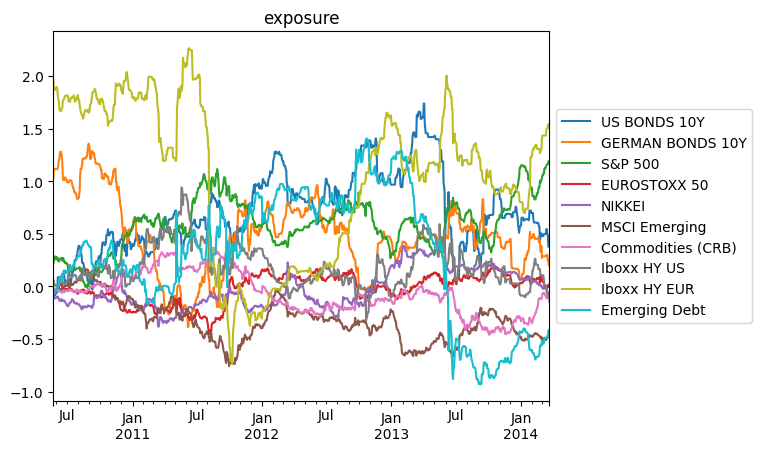

In [ ]:
import matplotlib.pyplot as plt

X_strategy.tail(1000).plot(title='exposure')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

On peut visualiser le rendement cumule

<Axes: >

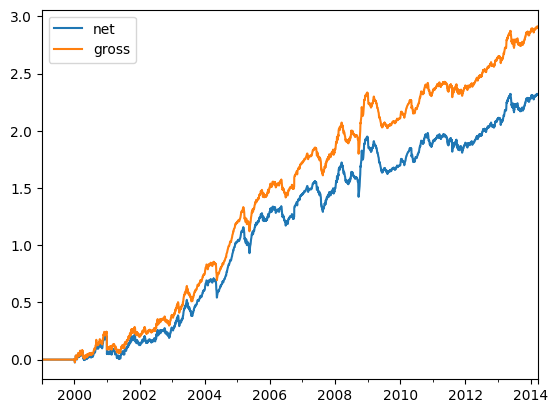

In [ ]:
strategy_returns = X_strategy.shift()*R


c = 10/100/100
tcost = X_strategy.diff().abs()*c
tcost_tot = tcost.sum(1)

strategy_returns_net = (strategy_returns.sum(1) - tcost_tot)

pd.DataFrame({'net':strategy_returns_net,'gross':(strategy_returns).sum(1)}).cumsum().plot()

Calculer le ratio de Sharpe

In [ ]:
mu = strategy_returns_net.mean()*260
vol = strategy_returns_net.std()*260**0.5
SR = mu/vol
SR

1.2053424780970228

##Smart beta: Regularization du portefeuille Minimum Variance

Le portefeuille de minimum variance fait intervenir l'inverse matrice de variance covariance, la matrice d'information $\mathcal{I}=\Sigma^{-1}$. Quand le nombre d'actif est tres grand cela peut donner des solutions qui ont tendance a overfiter. Pour le comprendre on va s'interesser a la relation entre l'inverse et la regression lineraire.


Stevens (1998) donne une nouvelle interpretation de la matrice d'information a traers la relation lineaire suivante

$$R_{i, t}=\beta_{0}+\beta_{i}^{\top} R_{t}^{(-i)}+\varepsilon_{i, t}$$



ou $R_{t}^{(-i)}$ est le vecteur des rendement $R_{t}$ sans  le $i^{\text {th }}$ asset et $\varepsilon_{i, t} \sim \mathcal{N}\left(0, s_{i}^{2}\right)$. Si $R_{i}^{2}$ est le R-squared de la  regression et $\hat{\beta}$ la matrices contenante ;es solutions des problemes de regressios en ligne. Stevens (1998) montre que les elements diagonaux de la matrice d'information sont donnes par:
$$
\mathcal{I}_{i, i}=\frac{1}{\hat{\sigma}_{i}^{2}\left(1-R_{i}^{2}\right)}
$$
Et les elements off diagonaux par:
$$
\mathcal{I}_{i, j}=-\frac{\hat{\beta}_{i, j}}{\hat{\sigma}_{i}^{2}\left(1-R_{i}^{2}\right)}=-\frac{\hat{\beta}_{j, i}}{\hat{\sigma}_{j}^{2}\left(1-R_{j}^{2}\right)}
$$
En utilisant cette formulation de $\mathcal{I}$, on obtient une nouvelle formule pour le portefeuille de minimum variance:
$$
x_{i}^{\star}(\lambda)=\lambda \frac{1-\hat{\beta}_{i}^{\top} \mathbf{1}}{\hat{\sigma}_{i}^{2}\left(1-R_{i}^{2}\right)}
$$
  En se rappellant que $R_{i}^{2}=1-\hat{s}_{i}^{2} / \hat{\sigma}_{i}^{2} .$ on obtient finalement:

$$
x_{i}^{\star}(\lambda)=\lambda \frac{1-\widehat{\beta}_{i}^{\top} \mathbf{1}}{\hat{s}_{i}^{2}}
$$
On en deduit que:
  * Meilleurs est le hedge plus large est l'exposition (car on divise par la variance du residu)
  * le signe depend de $1-\sum_j\beta_j$ 


Pour regulariser le minimum variance il suffit alors d'utiliser les contraintes de norme sur les regressions. On peut alors utiliser le R2 out sample et sparsifier les relations (par exemple voir table 19 [ici](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2767358))


In [ ]:
#l'inverse de la mtrice de covar de note univers est
cov = R.T@R
I = np.linalg.inv(cov)
pd.DataFrame(I,columns=R.columns,index=R.columns)

,US BONDS 10Y,GERMAN BONDS 10Y,S&P 500,EUROSTOXX 50,NIKKEI,MSCI Emerging,Commodities (CRB),Iboxx HY US,Iboxx HY EUR,Emerging Debt
US BONDS 10Y,26.133551,-16.126166,1.301190,0.040839,0.337343,0.001421,0.387195,-0.742799,0.671427,-1.788568
GERMAN BONDS 10Y,-16.126166,35.979989,-1.163769,2.176051,0.266320,0.611908,-0.097276,0.798841,-0.348018,-2.119659
S&P 500,1.301190,-1.163769,3.278198,-0.982965,-0.876895,-0.194168,0.018856,-1.089326,0.995605,-0.238785
EUROSTOXX 50,0.040839,2.176051,-0.982965,1.979479,0.001762,-0.412119,-0.099695,0.060910,-0.598461,-0.531841
NIKKEI,0.337343,0.266320,-0.876895,0.001762,1.926665,-0.571502,-0.029479,-0.490795,-0.012212,0.229056
MSCI Emerging,0.001421,0.611908,-0.194168,-0.412119,-0.571502,2.135144,-0.400839,-0.506240,-0.473027,-0.995921
Commodities (CRB),0.387195,-0.097276,0.018856,-0.099695,-0.029479,-0.400839,2.410440,-0.505626,-0.215496,-0.046277
Iboxx HY US,-0.742799,0.798841,-1.089326,0.060910,-0.490795,-0.506240,-0.505626,8.043350,-1.571514,-0.808670
Iboxx HY EUR,0.671427,-0.348018,0.995605,-0.598461,-0.012212,-0.473027,-0.215496,-1.571514,16.193633,-1.565437
Emerging Debt,-1.788568,-2.119659,-0.238785,-0.531841,0.229056,-0.995921,-0.046277,-0.808670,-1.565437,9.522696


In [ ]:
#Calculons l'equivalent de la premiere ligne en utilisant la regression lineaire
y = R.values[:,0]
X = R.values[:,1:]
beta = np.linalg.inv(X.T@X)@X.T@y
s2 = sum((y-X@beta)**2)
first_row = np.concatenate([[1/s2],-beta.ravel()/s2])
pd.Series(first_row,index=R.columns) # on trouve bien la relation

US BONDS 10Y         26.133551
GERMAN BONDS 10Y    -16.126166
S&P 500               1.301190
EUROSTOXX 50          0.040839
NIKKEI                0.337343
MSCI Emerging         0.001421
Commodities (CRB)     0.387195
Iboxx HY US          -0.742799
Iboxx HY EUR          0.671427
Emerging Debt        -1.788568
dtype: float64

Voyons maintenant quelle serait la bonne relation en utilisant une regression Lasso cross validee

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
lassocv = LassoCV(fit_intercept=False,cv=TimeSeriesSplit(),)# on utilise un time series splitter
lassocv.fit(X,y)

LassoCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
        fit_intercept=False)

In [ ]:
s2_lasso = sum((y-X@lassocv.coef_)**2)
first_row_regularised = np.concatenate([[1/s2_lasso],lassocv.coef_/s2_lasso])
pd.DataFrame({'lasso':first_row_regularised,'ols':first_row},index=R.columns)

,lasso,ols
US BONDS 10Y,26.018000,26.133551
GERMAN BONDS 10Y,15.112636,-16.126166
S&P 500,-1.133672,1.301190
EUROSTOXX 50,-0.108744,0.040839
NIKKEI,-0.314924,0.337343
MSCI Emerging,-0.000000,0.001421
Commodities (CRB),-0.279659,0.387195
Iboxx HY US,0.237639,-0.742799
Iboxx HY EUR,-0.000000,0.671427
Emerging Debt,1.440361,-1.788568


In [ ]:
#ce qui nous donne le poids US bonds pour chacune des methodes
pd.DataFrame({'lasso':first_row_regularised,'ols':first_row}).sum(0)

lasso    40.971636
ols      10.215433
dtype: float64